<h1 style="text-align:center;font-size:30px;" > Quora Question Pairs </h1>

<h1> 1. Business Problem </h1>

<h2> 1.1 Description </h2>

<p>Quora is a place to gain and share knowledge—about anything. It’s a platform to ask questions and connect with people who contribute unique insights and quality answers. This empowers people to learn from each other and to better understand the world.</p>
<p>
Over 100 million people visit Quora every month, so it's no surprise that many people ask similarly worded questions. Multiple questions with the same intent can cause seekers to spend more time finding the best answer to their question, and make writers feel they need to answer multiple versions of the same question. Quora values canonical questions because they provide a better experience to active seekers and writers, and offer more value to both of these groups in the long term.
</p>
<br>
> Credits: Kaggle 


__ Problem Statement __
- Identify which questions asked on Quora are duplicates of questions that have already been asked. 
- This could be useful to instantly provide answers to questions that have already been answered. 
- We are tasked with predicting whether a pair of questions are duplicates or not. 

<h2> 1.2 Sources/Useful Links</h2>

- Source : https://www.kaggle.com/c/quora-question-pairs
<br><br>____ Useful Links ____
- Discussions : https://www.kaggle.com/anokas/data-analysis-xgboost-starter-0-35460-lb/comments
- Kaggle Winning Solution and other approaches: https://www.dropbox.com/sh/93968nfnrzh8bp5/AACZdtsApc1QSTQc7X0H3QZ5a?dl=0
- Blog 1 : https://engineering.quora.com/Semantic-Question-Matching-with-Deep-Learning
- Blog 2 : https://towardsdatascience.com/identifying-duplicate-questions-on-quora-top-12-on-kaggle-4c1cf93f1c30

<h2>1.3 Real world/Business Objectives and Constraints </h2>

1. The cost of a mis-classification can be very high.
2. You would want a probability of a pair of questions to be duplicates so that you can choose any threshold of choice.
3. No strict latency concerns.
4. Interpretability is partially important.

<h1>2. Machine Learning Probelm </h1>

<h2> 2.1 Data </h2>

<h3> 2.1.1 Data Overview </h3>

<p> 
- Data will be in a file Train.csv <br>
- Train.csv contains 5 columns : qid1, qid2, question1, question2, is_duplicate <br>
- Size of Train.csv - 60MB <br>
- Number of rows in Train.csv = 404,290
</p>

<h3> 2.1.2 Example Data point </h3>

<pre>
"id","qid1","qid2","question1","question2","is_duplicate"
"0","1","2","What is the step by step guide to invest in share market in india?","What is the step by step guide to invest in share market?","0"
"1","3","4","What is the story of Kohinoor (Koh-i-Noor) Diamond?","What would happen if the Indian government stole the Kohinoor (Koh-i-Noor) diamond back?","0"
"7","15","16","How can I be a good geologist?","What should I do to be a great geologist?","1"
"11","23","24","How do I read and find my YouTube comments?","How can I see all my Youtube comments?","1"
</pre>

<h2> 2.2 Mapping the real world problem to an ML problem </h2>

<h3> 2.2.1 Type of Machine Leaning Problem </h3>

<p> It is a binary classification problem, for a given pair of questions we need to predict if they are duplicate or not. </p>

<h3> 2.2.2 Performance Metric </h3>

Source: https://www.kaggle.com/c/quora-question-pairs#evaluation

Metric(s): 
* log-loss : https://www.kaggle.com/wiki/LogarithmicLoss
* Binary Confusion Matrix

<h2> 2.3 Train and Test Construction </h2>

<p>  </p>
<p> We build train and test by randomly splitting in the ratio of 70:30 or 80:20 whatever we choose as we have sufficient points to work with. </p>

<h1>3. Exploratory Data Analysis </h1>

In [0]:
import warnings
warnings.filterwarnings("ignore")

import sys
import os
import gc
import re
import time
import distance
import spacy
import sqlite3
import csv
import math

import datetime as dt
from tqdm import tqdm
from os import path
from PIL import Image

import numpy as np
import pandas as pd
from collections import Counter, defaultdict

import seaborn as sns
import matplotlib.pyplot as plt
from subprocess import check_output
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
from bs4 import BeautifulSoup
from wordcloud import WordCloud, STOPWORDS

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from fuzzywuzzy import fuzz

from sklearn.preprocessing import MinMaxScaler

from sklearn.manifold import TSNE
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold 
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDClassifier
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, auc, roc_curve
from mlxtend.classifier import StackingClassifier

from scipy.sparse import hstack

from sqlalchemy import create_engine # database connection

import xgboost as xgb
from xgboost.sklearn import XGBClassifier

In [0]:
!pip install distance
!pip install fuzzywuzzy

    100% |████████████████████████████████| 184kB 6.1MB/s 
  Stored in directory: /root/.cache/pip/wheels/d5/aa/e1/dbba9e7b6d397d645d0f12db1c66dbae9c5442b39b001db18e
Successfully built distance


<h2> 3.1 Reading data and basic stats </h2>

In [0]:
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/


In [0]:
df = pd.read_csv("/content/drive/My Drive/Quora/train.csv")


print("Number of data points:",df.shape[0])

Number of data points: 404290


In [0]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [0]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
id              404290 non-null int64
qid1            404290 non-null int64
qid2            404290 non-null int64
question1       404289 non-null object
question2       404288 non-null object
is_duplicate    404290 non-null int64
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


We are given a minimal number of data fields here, consisting of:

- id:  Looks like a simple rowID
- qid{1, 2}:  The unique ID of each question in the pair
- question{1, 2}:  The actual textual contents of the questions.
- is_duplicate:  The label that we are trying to predict - whether the two questions are duplicates of each other.

<h2> 3.2 Distribution of data points among output classes</h2>

Number of duplicate(smilar) and non-duplicate(non similar) questions

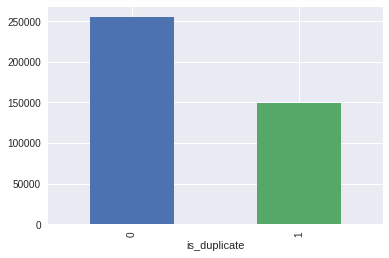

In [0]:
df.groupby("is_duplicate")['id'].count().plot.bar()

In [0]:
print('~> Total number of question pairs for training:\n   {}'.format(len(df)))

~> Total number of question pairs for training:
   404290


In [0]:
print('~> Question pairs are not Similar (is_duplicate = 0):\n   {}%'.format(100 - round(df['is_duplicate'].mean()*100, 2)))
print('\n~> Question pairs are Similar (is_duplicate = 1):\n   {}%'.format(round(df['is_duplicate'].mean()*100, 2)))

~> Question pairs are not Similar (is_duplicate = 0):
   63.08%

~> Question pairs are Similar (is_duplicate = 1):
   36.92%


<h3> 3.2.1 Number of unique questions </h3>

In [0]:
qids = pd.Series(df['qid1'].tolist() + df['qid2'].tolist())
unique_qs = len(np.unique(qids))
qs_morethan_onetime = np.sum(qids.value_counts() > 1)
print ('Total number of  Unique Questions are: {}\n'.format(unique_qs))
#print len(np.unique(qids))

print ('Number of unique questions that appear more than one time: {} ({}%)\n'.format(qs_morethan_onetime,qs_morethan_onetime/unique_qs*100))

print ('Max number of times a single question is repeated: {}\n'.format(max(qids.value_counts()))) 

q_vals=qids.value_counts()

q_vals=q_vals.values

Total number of  Unique Questions are: 537933

Number of unique questions that appear more than one time: 111780 (20.77953945937505%)

Max number of times a single question is repeated: 157



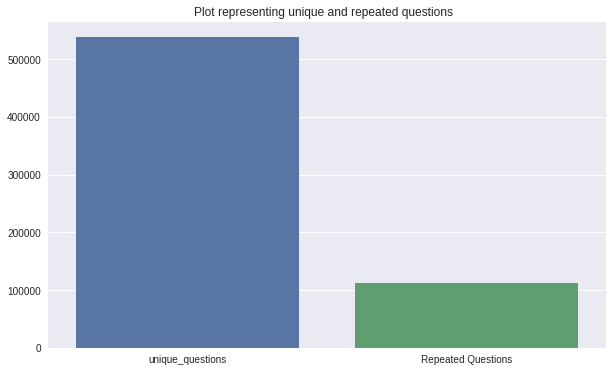

In [0]:

x = ["unique_questions" , "Repeated Questions"]
y =  [unique_qs , qs_morethan_onetime]

plt.figure(figsize=(10, 6))
plt.title ("Plot representing unique and repeated questions  ")
sns.barplot(x,y)
plt.show()

<h3>3.2.2 Checking for Duplicates </h3>

In [0]:
#checking whether there are any repeated pair of questions

pair_duplicates = df[['qid1','qid2','is_duplicate']].groupby(['qid1','qid2']).count().reset_index()

print ("Number of duplicate questions",(pair_duplicates).shape[0] - df.shape[0])

Number of duplicate questions 0


<h3> 3.2.3 Number of occurrences of each question </h3>

Maximum number of times a single question is repeated: 157



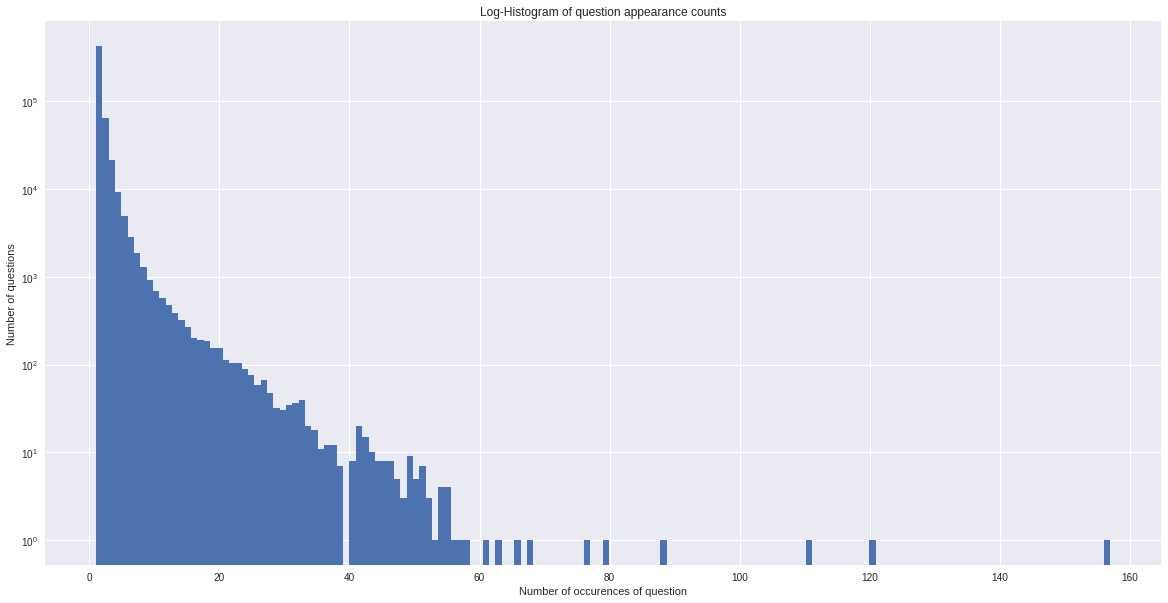

In [0]:
plt.figure(figsize=(20, 10))

plt.hist(qids.value_counts(), bins=160)

plt.yscale('log', nonposy='clip')

plt.title('Log-Histogram of question appearance counts')

plt.xlabel('Number of occurences of question')

plt.ylabel('Number of questions')

print ('Maximum number of times a single question is repeated: {}\n'.format(max(qids.value_counts()))) 

<h3> 3.2.4 Checking for NULL values </h3>

In [0]:
#Checking whether there are any rows with null values
nan_rows = df[df.isnull().any(1)]
print (nan_rows)

            id    qid1    qid2                         question1  \
105780  105780  174363  174364    How can I develop android app?   
201841  201841  303951  174364  How can I create an Android app?   
363362  363362  493340  493341                               NaN   

                                                question2  is_duplicate  
105780                                                NaN             0  
201841                                                NaN             0  
363362  My Chinese name is Haichao Yu. What English na...             0  


- There are two rows with null values in question2 

In [0]:
# Filling the null values with ' '
df = df.fillna('')
nan_rows = df[df.isnull().any(1)]
print (nan_rows)

Empty DataFrame
Columns: [id, qid1, qid2, question1, question2, is_duplicate]
Index: []


<h2>3.3 Basic Feature Extraction (before cleaning) </h2>

Let us now construct a few features like:
 - ____freq_qid1____ = Frequency of qid1's
 - ____freq_qid2____ = Frequency of qid2's 
 - ____q1len____ = Length of q1
 - ____q2len____ = Length of q2
 - ____q1_n_words____ = Number of words in Question 1
 - ____q2_n_words____ = Number of words in Question 2
 - ____word_Common____ = (Number of common unique words in Question 1 and Question 2)
 - ____word_Total____ =(Total num of words in Question 1 + Total num of words in Question 2)
 - ____word_share____ = (word_common)/(word_Total)
 - ____freq_q1+freq_q2____ = sum total of frequency of qid1 and qid2 
 - ____freq_q1-freq_q2____ = absolute difference of frequency of qid1 and qid2 

In [0]:
if  os.path.isfile('/content/drive/My Drive/quora/df_fe_without_preprocessing_train.csv'):
    df = pd.read_csv('/content/drive/My Drive/quora/df_fe_without_preprocessing_train.csv',encoding='latin-1')
    print("yes")
else:
    print("no")
    df['freq_qid1'] = df.groupby('qid1')['qid1'].transform('count') 
    df['freq_qid2'] = df.groupby('qid2')['qid2'].transform('count')
    df['q1len'] = df['question1'].str.len() 
    df['q2len'] = df['question2'].str.len()
    df['q1_n_words'] = df['question1'].apply(lambda row: len(row.split(" ")))
    df['q2_n_words'] = df['question2'].apply(lambda row: len(row.split(" ")))

    def normalized_word_Common(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
        return 1.0 * len(w1 & w2)
    df['word_Common'] = df.apply(normalized_word_Common, axis=1)

    def normalized_word_Total(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
        return 1.0 * (len(w1) + len(w2))
    df['word_Total'] = df.apply(normalized_word_Total, axis=1)

    def normalized_word_share(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
        return 1.0 * len(w1 & w2)/(len(w1) + len(w2))
    df['word_share'] = df.apply(normalized_word_share, axis=1)

    df['freq_q1+q2'] = df['freq_qid1']+df['freq_qid2']
    df['freq_q1-q2'] = abs(df['freq_qid1']-df['freq_qid2'])

    df.to_csv("/content/drive/My Drive/quora/df_fe_without_preprocessing_train.csv", index=False)

df.head()

yes


,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,14,12,10.0,23.0,0.434783,2,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,4,1,51,88,8,13,4.0,20.0,0.200000,5,3
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,1,1,73,59,14,10,4.0,24.0,0.166667,2,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,1,1,50,65,11,9,0.0,19.0,0.000000,2,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,3,1,76,39,13,7,2.0,20.0,0.100000,4,2


<h3> 3.3.1 Analysis of some of the extracted features </h3>

- Here are some questions have only one single words.

In [0]:
print ("Minimum length of the questions in question1 : " , min(df['q1_n_words']))

print ("Minimum length of the questions in question2 : " , min(df['q2_n_words']))

print ("Number of Questions with minimum length [question1] :", df[df['q1_n_words']== 1].shape[0])
print ("Number of Questions with minimum length [question2] :", df[df['q2_n_words']== 1].shape[0])

Minimum length of the questions in question1 :  1
Minimum length of the questions in question2 :  1
Number of Questions with minimum length [question1] : 67
Number of Questions with minimum length [question2] : 24


<h4> 3.3.1.1 Feature: word_share </h4>

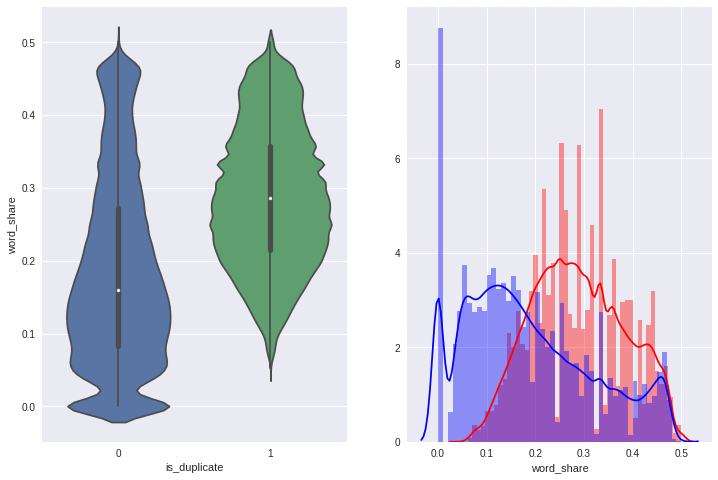

In [0]:
plt.figure(figsize=(12, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'word_share', data = df[0:])

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['word_share'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['word_share'][0:] , label = "0" , color = 'blue' )
plt.show()

- The distributions for normalized word_share have some overlap on the far right-hand side, i.e., there are quite a lot of questions with high word similarity
- The average word share and Common no. of words of qid1 and qid2 is more when they are duplicate(Similar)

<h4> 3.3.1.2 Feature: word_Common </h4>

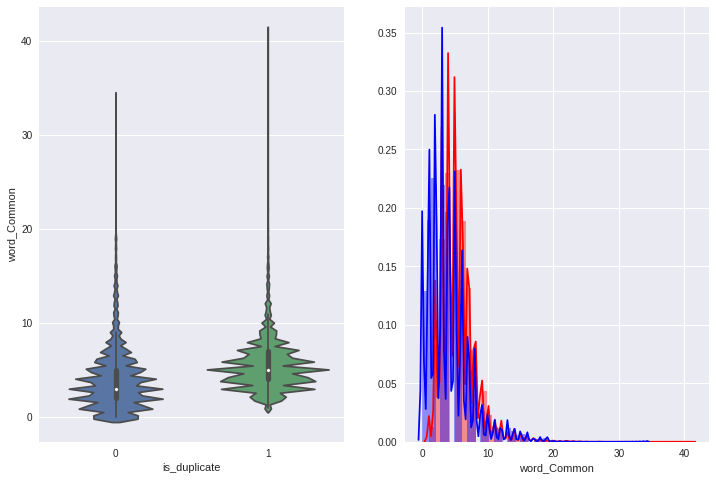

In [0]:
plt.figure(figsize=(12, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'word_Common', data = df[0:])

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['word_Common'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['word_Common'][0:] , label = "0" , color = 'blue' )
plt.show()

<p> The distributions of the word_Common feature in similar and non-similar questions are highly overlapping </p>

<h2>3.4 EDA: Advanced Feature Extraction. </h2>

In [0]:
#https://stackoverflow.com/questions/12468179/unicodedecodeerror-utf8-codec-cant-decode-byte-0x9c
if os.path.isfile("/content/drive/My Drive/quora/df_fe_without_preprocessing_train.csv"):
    df = pd.read_csv("/content/drive/My Drive/quora/df_fe_without_preprocessing_train.csv",encoding='latin-1')
    df = df.fillna('')    
else:
    print("get df_fe_without_preprocessing_train.csv from drive or run the previous notebook")

In [0]:
df.head(2)

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,14,12,10.0,23.0,0.434783,2,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,4,1,51,88,8,13,4.0,20.0,0.200000,5,3


<h2> 3.5 Preprocessing of Text </h2>

- Preprocessing:
    - Removing html tags 
    - Removing Punctuations
    - Performing stemming
    - Removing Stopwords
    - Expanding contractions etc.

- Function to Compute and get the features : With 2 parameters of Question 1 and Question 2

In [0]:
import nltk 
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [0]:
# To get the results in 4 decimal points
SAFE_DIV = 0.0001 

STOP_WORDS = stopwords.words("english")


def preprocess(x):
    x = str(x).lower()
    x = x.replace(",000,000", "m").replace(",000", "k").replace("′", "'").replace("’", "'")\
                           .replace("won't", "will not").replace("cannot", "can not").replace("can't", "can not")\
                           .replace("n't", " not").replace("what's", "what is").replace("it's", "it is")\
                           .replace("'ve", " have").replace("i'm", "i am").replace("'re", " are")\
                           .replace("he's", "he is").replace("she's", "she is").replace("'s", " own")\
                           .replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ")\
                           .replace("€", " euro ").replace("'ll", " will")
    x = re.sub(r"([0-9]+)000000", r"\1m", x)
    x = re.sub(r"([0-9]+)000", r"\1k", x)
    
    
    porter = PorterStemmer()
    pattern = re.compile('\W')
    
    if type(x) == type(''):
        x = re.sub(pattern, ' ', x)
    
    
    if type(x) == type(''):
        x = porter.stem(x)
        example1 = BeautifulSoup(x)
        x = example1.get_text()
               
    
    return x

<h2> 3.6 Advanced Feature Extraction (NLP and Fuzzy Features) </h2>

Definition:
- __Token__: You get a token by splitting sentence a space
- __Stop_Word__ : stop words as per NLTK.
- __Word__ : A token that is not a stop_word


Features:
- __cwc_min__ :  Ratio of common_word_count to min lenghth of word count of Q1 and Q2 <br>cwc_min = common_word_count / (min(len(q1_words), len(q2_words))
<br>
<br>
- __cwc_max__ :  Ratio of common_word_count to max lenghth of word count of Q1 and Q2 <br>cwc_max = common_word_count / (max(len(q1_words), len(q2_words))
<br>
<br>
- __csc_min__ :  Ratio of common_stop_count to min lenghth of stop count of Q1 and Q2 <br> csc_min = common_stop_count / (min(len(q1_stops), len(q2_stops))
<br>
<br>
- __csc_max__ :  Ratio of common_stop_count to max lenghth of stop count of Q1 and Q2<br>csc_max = common_stop_count / (max(len(q1_stops), len(q2_stops))
<br>
<br>
- __ctc_min__ :  Ratio of common_token_count to min lenghth of token count of Q1 and Q2<br>ctc_min = common_token_count / (min(len(q1_tokens), len(q2_tokens))
<br>
<br>
- __ctc_max__ :  Ratio of common_token_count to max lenghth of token count of Q1 and Q2<br>ctc_max = common_token_count / (max(len(q1_tokens), len(q2_tokens))
<br>
<br>        
- __last_word_eq__ :  Check if First word of both questions is equal or not<br>last_word_eq = int(q1_tokens[-1] == q2_tokens[-1])
<br>
<br>
- __first_word_eq__ :  Check if First word of both questions is equal or not<br>first_word_eq = int(q1_tokens[0] == q2_tokens[0])
<br>
<br>        
- __abs_len_diff__ :  Abs. length difference<br>abs_len_diff = abs(len(q1_tokens) - len(q2_tokens))
<br>
<br>
- __mean_len__ :  Average Token Length of both Questions<br>mean_len = (len(q1_tokens) + len(q2_tokens))/2
<br>
<br>
- __fuzz_ratio__ :  https://github.com/seatgeek/fuzzywuzzy#usage  <br>
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>
- __fuzz_partial_ratio__ :  https://github.com/seatgeek/fuzzywuzzy#usage  <br>
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>
- __token_sort_ratio__ : https://github.com/seatgeek/fuzzywuzzy#usage  <br>
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>
- __token_set_ratio__ : https://github.com/seatgeek/fuzzywuzzy#usage  <br>
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>
- __longest_substr_ratio__ :  Ratio of length longest common substring to min lenghth of token count of Q1 and Q2<br>longest_substr_ratio = len(longest common substring) / (min(len(q1_tokens), len(q2_tokens))

In [0]:
def get_token_features(q1, q2):
    token_features = [0.0]*10
    
    # Converting the Sentence into Tokens: 
    q1_tokens = q1.split()
    q2_tokens = q2.split()

    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return token_features
    # Get the non-stopwords in Questions
    q1_words = set([word for word in q1_tokens if word not in STOP_WORDS])
    q2_words = set([word for word in q2_tokens if word not in STOP_WORDS])
    
    #Get the stopwords in Questions
    q1_stops = set([word for word in q1_tokens if word in STOP_WORDS])
    q2_stops = set([word for word in q2_tokens if word in STOP_WORDS])
    
    # Get the common non-stopwords from Question pair
    common_word_count = len(q1_words.intersection(q2_words))
    
    # Get the common stopwords from Question pair
    common_stop_count = len(q1_stops.intersection(q2_stops))
    
    # Get the common Tokens from Question pair
    common_token_count = len(set(q1_tokens).intersection(set(q2_tokens)))
    
    
    token_features[0] = common_word_count / (min(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[1] = common_word_count / (max(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[2] = common_stop_count / (min(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[3] = common_stop_count / (max(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[4] = common_token_count / (min(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    token_features[5] = common_token_count / (max(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    
    # Last word of both question is same or not
    token_features[6] = int(q1_tokens[-1] == q2_tokens[-1])
    
    # First word of both question is same or not
    token_features[7] = int(q1_tokens[0] == q2_tokens[0])
    
    token_features[8] = abs(len(q1_tokens) - len(q2_tokens))
    
    #Average Token Length of both Questions
    token_features[9] = (len(q1_tokens) + len(q2_tokens))/2
    return token_features

# get the Longest Common sub string

def get_longest_substr_ratio(a, b):
    strs = list(distance.lcsubstrings(a, b))
    if len(strs) == 0:
        return 0
    else:
        return len(strs[0]) / (min(len(a), len(b)) + 1)

def extract_features(df):
    # preprocessing each question
    df["question1"] = df["question1"].fillna("").apply(preprocess)
    df["question2"] = df["question2"].fillna("").apply(preprocess)

    print("token features...")
    
    # Merging Features with dataset
    
    token_features = df.apply(lambda x: get_token_features(x["question1"], x["question2"]), axis=1)
    
    df["cwc_min"]       = list(map(lambda x: x[0], token_features))
    df["cwc_max"]       = list(map(lambda x: x[1], token_features))
    df["csc_min"]       = list(map(lambda x: x[2], token_features))
    df["csc_max"]       = list(map(lambda x: x[3], token_features))
    df["ctc_min"]       = list(map(lambda x: x[4], token_features))
    df["ctc_max"]       = list(map(lambda x: x[5], token_features))
    df["last_word_eq"]  = list(map(lambda x: x[6], token_features))
    df["first_word_eq"] = list(map(lambda x: x[7], token_features))
    df["abs_len_diff"]  = list(map(lambda x: x[8], token_features))
    df["mean_len"]      = list(map(lambda x: x[9], token_features))
   
    #Computing Fuzzy Features and Merging with Dataset
    
    # do read this blog: http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
    # https://stackoverflow.com/questions/31806695/when-to-use-which-fuzz-function-to-compare-2-strings
    # https://github.com/seatgeek/fuzzywuzzy
    print("fuzzy features..")

    df["token_set_ratio"]       = df.apply(lambda x: fuzz.token_set_ratio(x["question1"], x["question2"]), axis=1)
    # The token sort approach involves tokenizing the string in question, sorting the tokens alphabetically, and 
    # then joining them back into a string We then compare the transformed strings with a simple ratio().
    df["token_sort_ratio"]      = df.apply(lambda x: fuzz.token_sort_ratio(x["question1"], x["question2"]), axis=1)
    df["fuzz_ratio"]            = df.apply(lambda x: fuzz.QRatio(x["question1"], x["question2"]), axis=1)
    df["fuzz_partial_ratio"]    = df.apply(lambda x: fuzz.partial_ratio(x["question1"], x["question2"]), axis=1)
    df["longest_substr_ratio"]  = df.apply(lambda x: get_longest_substr_ratio(x["question1"], x["question2"]), axis=1)
    return df

In [0]:
"/content/drive/My Drive/quora/df_fe_without_preprocessing_train.csv"
if os.path.isfile('/content/drive/My Drive/quora/nlp_features_train.csv'):
    df = pd.read_csv("/content/drive/My Drive/quora/nlp_features_train.csv",encoding='latin-1')
    df.fillna('')
else:
    print("Extracting features for train:")
    df = pd.read_csv("/content/drive/My Drive/Quora/train.csv")
    df = extract_features(df)
    df.to_csv("/content/drive/My Drive/quora/nlp_features_train.csv", index=False)
df.head(2)

Extracting features for train:
token features...
fuzzy features..


,id,qid1,qid2,question1,question2,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,...,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,0.999980,0.833319,0.999983,0.999983,...,0.785709,0.0,1.0,2.0,13.0,100,93,93,100,0.982759
1,1,3,4,what is the story of kohinoor koh i noor dia...,what would happen if the indian government sto...,0,0.799984,0.399996,0.749981,0.599988,...,0.466664,0.0,1.0,5.0,12.5,86,63,66,75,0.596154


<h2>3.7 Analysis of extracted features </h2>

<h3> 3.7.1 Plotting Word clouds</h3>

- Creating Word Cloud of Duplicates and Non-Duplicates Question pairs
- We can observe the most frequent occuring words

In [0]:
df_duplicate = df[df['is_duplicate'] == 1]
dfp_nonduplicate = df[df['is_duplicate'] == 0]

# Converting 2d array of q1 and q2 and flatten the array: like {{1,2},{3,4}} to {1,2,3,4}
p = np.dstack([df_duplicate["question1"], df_duplicate["question2"]]).flatten()
n = np.dstack([dfp_nonduplicate["question1"], dfp_nonduplicate["question2"]]).flatten()

print ("Number of data points in class 1 (duplicate pairs) :",len(p))
print ("Number of data points in class 0 (non duplicate pairs) :",len(n))

#Saving the np array into a text file
np.savetxt('train_p.txt', p, delimiter=' ', fmt='%s',encoding="utf-8")
np.savetxt('train_n.txt', n, delimiter=' ', fmt='%s',encoding="utf-8")

Number of data points in class 1 (duplicate pairs) : 298526
Number of data points in class 0 (non duplicate pairs) : 510054


In [0]:
# reading the text files and removing the Stop Words:
d = path.dirname('.')

textp_w = open(path.join(d, 'train_p.txt')).read()
textn_w = open(path.join(d, 'train_n.txt')).read()
stopwords = set(STOPWORDS)
stopwords.add("said")
stopwords.add("br")
stopwords.add(" ")
stopwords.remove("not")

stopwords.remove("no")
#stopwords.remove("good")
#stopwords.remove("love")
stopwords.remove("like")
#stopwords.remove("best")
#stopwords.remove("!")
print ("Total number of words in duplicate pair questions :",len(textp_w))
print ("Total number of words in non duplicate pair questions :",len(textn_w))

Total number of words in duplicate pair questions : 16109886
Total number of words in non duplicate pair questions : 33193067


__ Word Clouds generated from  duplicate pair question's text __

Word Cloud for Duplicate Question pairs


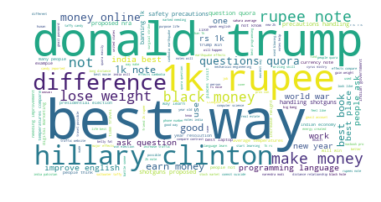

In [0]:
wc = WordCloud(background_color="white", max_words=len(textp_w), stopwords=stopwords)
wc.generate(textp_w)
print ("Word Cloud for Duplicate Question pairs")
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

__ Word Clouds generated from non duplicate pair question's text __

Word Cloud for non-Duplicate Question pairs:


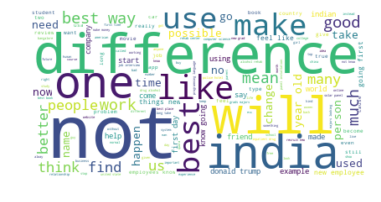

In [0]:
wc = WordCloud(background_color="white", max_words=len(textn_w),stopwords=stopwords)
# generate word cloud
wc.generate(textn_w)
print ("Word Cloud for non-Duplicate Question pairs:")
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

<h3> 3.7.2 Pair plot of features ['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio'] </h3>

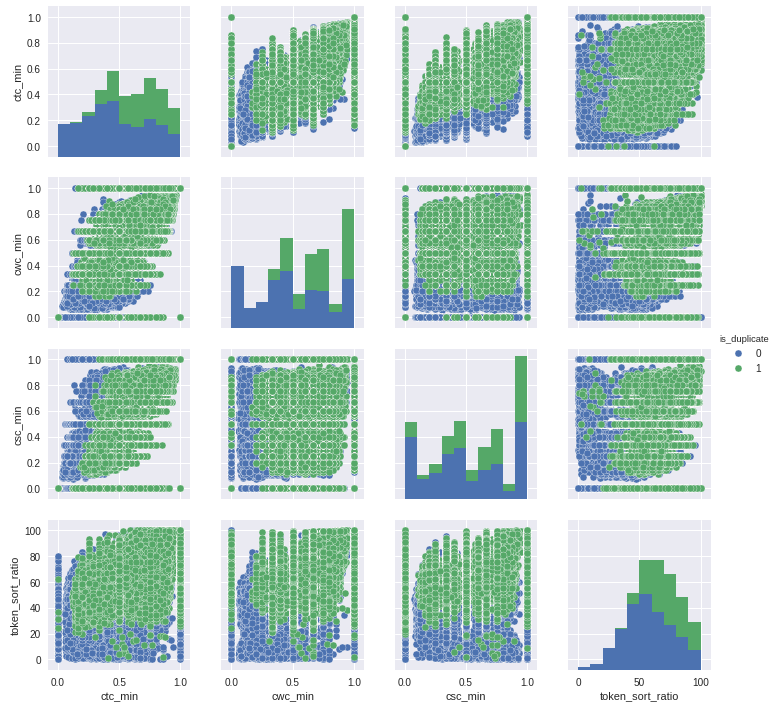

In [0]:
n = df.shape[0]
sns.pairplot(df[['ctc_min', 
                 'cwc_min', 
                 'csc_min', 
                 'token_sort_ratio', 
                 'is_duplicate']][0:n], 
             hue='is_duplicate', 
             vars=['ctc_min', 
                   'cwc_min', 
                   'csc_min', 
                   'token_sort_ratio'])
plt.show()

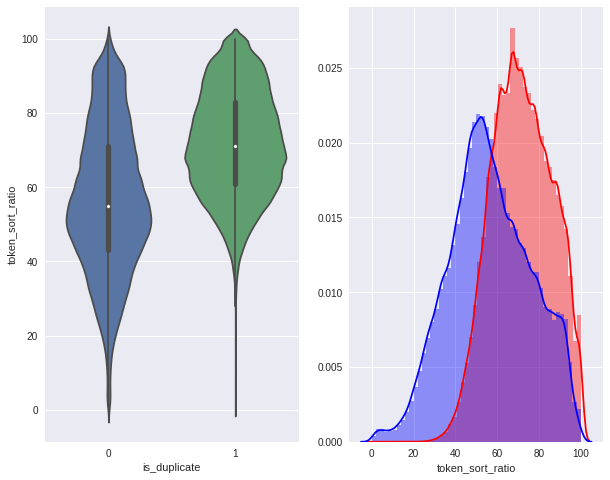

In [0]:
# Distribution of the token_sort_ratio
plt.figure(figsize=(10, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'token_sort_ratio', data = df[0:] , )

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['token_sort_ratio'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['token_sort_ratio'][0:] , label = "0" , color = 'blue' )
plt.show()

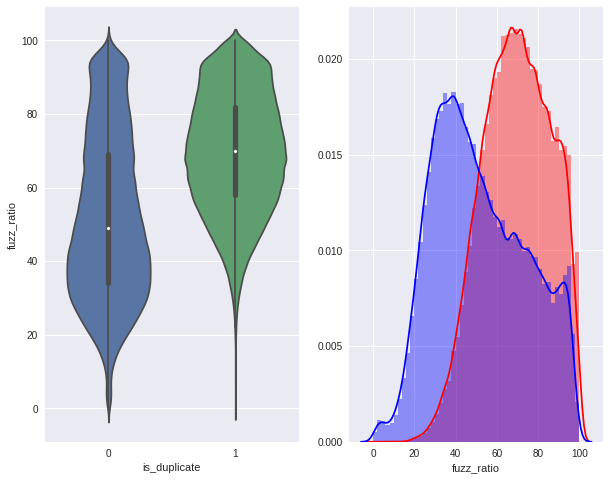

In [0]:
plt.figure(figsize=(10, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'fuzz_ratio', data = df[0:] , )

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['fuzz_ratio'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['fuzz_ratio'][0:] , label = "0" , color = 'blue' )
plt.show()

<h2>3.8Visualization </h2>



In [0]:
# Using TSNE for Dimentionality reduction for 15 Features(Generated after cleaning the data) to 3 dimention

from sklearn.preprocessing import MinMaxScaler

dfp_subsampled = df[0:5000]
X = MinMaxScaler().fit_transform(dfp_subsampled[['cwc_min', 'cwc_max', 'csc_min', 'csc_max' , 'ctc_min' , 'ctc_max' , 'last_word_eq', 'first_word_eq' , 'abs_len_diff' , 'mean_len' , 'token_set_ratio' , 'token_sort_ratio' ,  'fuzz_ratio' , 'fuzz_partial_ratio' , 'longest_substr_ratio']])
y = dfp_subsampled['is_duplicate'].values

In [0]:
tsne2d = TSNE(
    n_components=2,
    init='random', # pca
    random_state=101,
    method='barnes_hut',
    n_iter=1000,
    verbose=2,
    angle=0.5
).fit_transform(X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.013s...
[t-SNE] Computed neighbors for 5000 samples in 0.421s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.130446
[t-SNE] Computed conditional probabilities in 0.302s
[t-SNE] Iteration 50: error = 81.2911148, gradient norm = 0.0457501 (50 iterations in 2.940s)
[t-SNE] Iteration 100: error = 70.6044159, gradient norm = 0.0086692 (50 iterations in 2.018s)
[t-SNE] Iteration 150: error = 68.9124908, gradient norm = 0.0056016 (50 iterations in 1.939s)
[t-SNE] Iteration 200: error = 68.1010742, gradient norm = 0.0047585 (50 iterations in 2.008s)
[t-SNE] Iteration 250: error = 67.5907974, gradient norm = 0.0033576

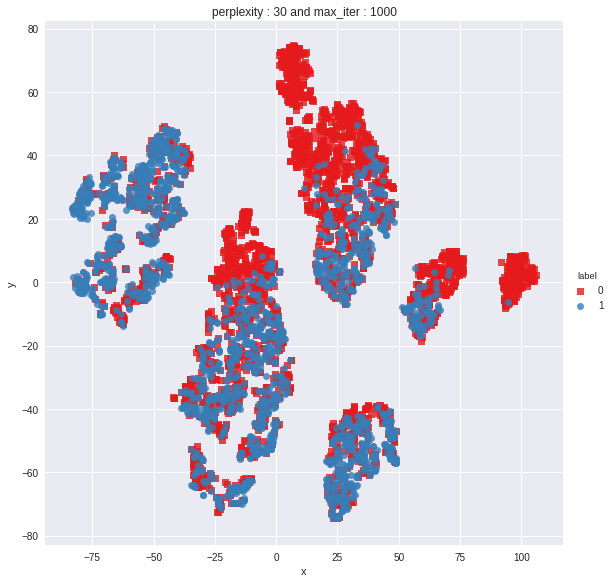

In [0]:
df = pd.DataFrame({'x':tsne2d[:,0], 'y':tsne2d[:,1] ,'label':y})

# draw the plot in appropriate place in the grid
sns.lmplot(data=df, x='x', y='y', hue='label', fit_reg=False, size=8,palette="Set1",markers=['s','o'])
plt.title("perplexity : {} and max_iter : {}".format(30, 1000))
plt.show()

In [0]:
tsne3d = TSNE(n_components=3,
              init='random', # pca
              random_state=101,
              method='barnes_hut',
              n_iter=1000,
              verbose=2,
              angle=0.5).fit_transform(X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.032s...
[t-SNE] Computed neighbors for 5000 samples in 0.442s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.130446
[t-SNE] Computed conditional probabilities in 0.310s
[t-SNE] Iteration 50: error = 80.5316772, gradient norm = 0.0296611 (50 iterations in 13.244s)
[t-SNE] Iteration 100: error = 69.3823166, gradient norm = 0.0032796 (50 iterations in 6.172s)
[t-SNE] Iteration 150: error = 67.9726028, gradient norm = 0.0016793 (50 iterations in 5.571s)
[t-SNE] Iteration 200: error = 67.4176178, gradient norm = 0.0010922 (50 iterations in 5.601s)
[t-SNE] Iteration 250: error = 67.1033630, gradient norm = 0.000883

In [0]:
trace1 = go.Scatter3d(
    x=tsne3d[:,0],
    y=tsne3d[:,1],
    z=tsne3d[:,2],
    mode='markers',
    marker=dict(
        sizemode='diameter',
        color = y,
        colorscale = 'Portland',
        colorbar = dict(title = 'duplicate'),
        line=dict(color='rgb(255, 255, 255)'),
        opacity=0.75
    )
)

data=[trace1]
layout=dict(height=800, width=800, title='3d embedding with engineered features')
fig=dict(data=data, layout=layout)
py.iplot(fig, filename='3DBubble')

<br>
<br>

<h1>4. Featurizing text data with tfidf weighted word-vectors </h1>

In [0]:
# avoid decoding problems
df = pd.read_csv("/content/drive/My Drive/Quora/train.csv")

# encode questions to unicode
# https://stackoverflow.com/a/6812069
# ----------------- python 2 ---------------------
# df['question1'] = df['question1'].apply(lambda x: unicode(str(x),"utf-8"))
# df['question2'] = df['question2'].apply(lambda x: unicode(str(x),"utf-8"))

df['question1'] = df['question1'].apply(lambda x: str(x))
df['question2'] = df['question2'].apply(lambda x: str(x))

In [0]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [0]:
#Balancing dataset
df = df.sort_values(by=['is_duplicate'])
df1_pos =df.iloc[:100000,:]
df2_neg =df.iloc[-100000:,:]
df_ = df1_pos.append(df2_neg, ignore_index=True)
data = df_.iloc[0:200000,:]# taking the first 2 lak reviews


print('~> Question pairs are not Similar (is_duplicate = 0):\n   {}%'.format(100 - round(data['is_duplicate'].mean()*100, 2)))
print('\n~> Question pairs are Similar (is_duplicate = 1):\n   {}%'.format(round(data['is_duplicate'].mean()*100, 2)))

y_true = data['is_duplicate']
data.drop(['is_duplicate'], axis=1, inplace=True)


#train test split
X_train_tfidf_w2v,X_test_tfidf_w2v, y_train_tfidf_w2v, y_test_tfidf_w2v, = train_test_split(data,y_true, test_size=0.3)
X_train_tfidf,X_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(data,y_true, test_size=0.3)

~> Question pairs are not Similar (is_duplicate = 0):
   62.76%

~> Question pairs are Similar (is_duplicate = 1):
   37.24%


In [0]:
print(data.head())

   id  qid1  qid2                                          question1  \
0   0     1     2  What is the step by step guide to invest in sh...   
1   1     3     4  What is the story of Kohinoor (Koh-i-Noor) Dia...   
2   2     5     6  How can I increase the speed of my internet co...   
3   3     7     8  Why am I mentally very lonely? How can I solve...   
4   4     9    10  Which one dissolve in water quikly sugar, salt...   

                                           question2  
0  What is the step by step guide to invest in sh...  
1  What would happen if the Indian government sto...  
2  How can Internet speed be increased by hacking...  
3  Find the remainder when [math]23^{24}[/math] i...  
4            Which fish would survive in salt water?  


In [0]:
# merge texts
questions_train = list(X_train_tfidf_w2v['question1']) + list(X_train_tfidf_w2v['question2'])
questions_test = list(X_test_tfidf_w2v['question1']) + list(X_test_tfidf_w2v['question2'])

tfidf = TfidfVectorizer(lowercase=False, )
tfidf.fit_transform(questions_train)
tfidf.transform(questions_test)

# dict key:word and value:tf-idf score
word2tfidf = dict(zip(tfidf.get_feature_names(), tfidf.idf_))

In [0]:
print(len(word2tfidf))

66992


In [0]:
print(type(X_test_tfidf_w2v['question1']))

<class 'pandas.core.series.Series'>


In [0]:
!python3 -m spacy download en_core_web_lg


    Linking successful
    /usr/local/lib/python3.6/dist-packages/en_core_web_lg -->
    /usr/local/lib/python3.6/dist-packages/spacy/data/en_core_web_lg

    You can now load the model via spacy.load('en_core_web_lg')



- After we find TF-IDF scores, we convert each question to a weighted average of word2vec vectors by these scores.
- here we use a pre-trained GLOVE model which comes free with "Spacy".  https://spacy.io/usage/vectors-similarity
- It is trained on Wikipedia and therefore, it is stronger in terms of word semantics. 

In [0]:
# en_vectors_web_lg, which includes over 1 million unique vectors.
nlp = spacy.load('en_core_web_lg')

def tfidf_w2v_model(list_of_sent): 
  vecs1 = []
  # https://github.com/noamraph/tqdm
  # tqdm is used to print the progress bar
  for qu1 in tqdm(list(list_of_sent)):
      doc1 = nlp(qu1) 
      # 384 is the number of dimensions of vectors 
      mean_vec1 = np.zeros([len(doc1), 300])
      for word1 in doc1:
          # word2vec
          vec1 = word1.vector
          # fetch df score
          try:
              idf = word2tfidf[str(word1)]
          except:
              idf = 0
          # compute final vec
          mean_vec1 += vec1 * idf
      mean_vec1 = mean_vec1.mean(axis=0)
      vecs1.append(mean_vec1)
  return list(vecs1)

X_train_tfidf_w2v['q1_feats_m'] =tfidf_w2v_model(X_train_tfidf_w2v['question1'])
X_train_tfidf_w2v['q2_feats_m'] =tfidf_w2v_model(X_train_tfidf_w2v['question2'])

X_test_tfidf_w2v['q1_feats_m'] =tfidf_w2v_model(X_test_tfidf_w2v['question1'])
X_test_tfidf_w2v['q2_feats_m'] =tfidf_w2v_model(X_test_tfidf_w2v['question2'])

100%|██████████| 60000/60000 [22:06<00:00, 45.24it/s]


In [0]:
#prepro_features_train.csv (Simple Preprocessing Feartures)
#nlp_features_train.csv (NLP Features)
if os.path.isfile('/content/drive/My Drive/quora/nlp_features_train.csv'):
    dfnlp = pd.read_csv("/content/drive/My Drive/quora/nlp_features_train.csv",encoding='latin-1')
else:
    print("download nlp_features_train.csv from drive or run previous notebook")

if os.path.isfile('/content/drive/My Drive/quora/df_fe_without_preprocessing_train.csv'):
    dfppro = pd.read_csv("/content/drive/My Drive/quora/df_fe_without_preprocessing_train.csv",encoding='latin-1')
else:
    print("download df_fe_without_preprocessing_train.csv from drive or run previous notebook")

In [0]:
df1 = dfnlp.drop(['qid1','qid2','question1','question2','is_duplicate'],axis=1)
df2 = dfppro.drop(['qid1','qid2','question1','question2','is_duplicate'],axis=1)
df3_train = X_train_tfidf_w2v.drop(['qid1','qid2','question1','question2'],axis=1)
df3_test = X_test_tfidf_w2v.drop(['qid1','qid2','question1','question2'],axis=1)
df3_q1_train = pd.DataFrame(df3_train.q1_feats_m.values.tolist(), index= df3_train.index)
df3_q2_train = pd.DataFrame(df3_train.q2_feats_m.values.tolist(), index= df3_train.index)
df3_q1_test = pd.DataFrame(df3_test.q1_feats_m.values.tolist(), index= df3_test.index)
df3_q2_test = pd.DataFrame(df3_test.q2_feats_m.values.tolist(), index= df3_test.index)

In [0]:
# dataframe of nlp features
print(df1.shape)
df1.head()

(404290, 16)


,id,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
0,0,0.999980,0.833319,0.999983,0.999983,0.916659,0.785709,0.0,1.0,2.0,13.0,100,93,93,100,0.982759
1,1,0.799984,0.399996,0.749981,0.599988,0.699993,0.466664,0.0,1.0,5.0,12.5,86,63,66,75,0.596154
2,2,0.399992,0.333328,0.399992,0.249997,0.399996,0.285712,0.0,1.0,4.0,12.0,63,63,43,47,0.166667
3,3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,2.0,12.0,28,24,9,14,0.039216
4,4,0.399992,0.199998,0.999950,0.666644,0.571420,0.307690,0.0,1.0,6.0,10.0,67,47,35,56,0.175000


In [0]:
# data before preprocessing 
print(df2.shape)
df2.head()

(404290, 12)


,id,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
0,0,1,1,66,57,14,12,10.0,23.0,0.434783,2,0
1,1,4,1,51,88,8,13,4.0,20.0,0.200000,5,3
2,2,1,1,73,59,14,10,4.0,24.0,0.166667,2,0
3,3,1,1,50,65,11,9,0.0,19.0,0.000000,2,0
4,4,3,1,76,39,13,7,2.0,20.0,0.100000,4,2


In [0]:
# Questions 1 tfidf weighted word2vec
print(df3_q1_train.shape)
df3_q1_train.head()

(140000, 300)


,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
5725,-9.714063,7.576855,-6.304685,-0.312969,3.460545,2.448915,3.974316,6.965653,-0.409209,70.071394,...,-7.666255,-1.337115,-4.250536,-1.257529,1.197851,4.611759,-3.255312,0.688763,-4.316223,3.477770
134334,1.738988,5.708785,-9.389472,-2.638631,-11.302602,6.529887,3.256669,-10.714409,-5.801472,97.984923,...,-17.105527,11.615498,-0.057997,5.275637,12.741180,-17.693032,-6.348803,-5.043604,-9.508088,3.331068
33611,-4.330260,7.648337,-1.857113,-2.962484,0.258171,-1.039636,0.453743,-4.702617,1.718224,41.910012,...,-9.229010,2.054532,-1.852921,-1.266328,3.355474,-0.950244,-3.599817,-5.479655,1.483623,2.431210
65293,-2.466800,5.460035,0.577316,-4.625728,6.805309,1.658395,-4.911580,-3.130546,-5.915695,57.451849,...,-17.502027,2.560114,3.913809,3.679332,7.856244,-2.444103,-5.339339,1.815246,-1.013213,5.026751
43803,-3.537932,7.256120,-5.519498,5.274830,-10.252761,-7.229738,-5.261336,-1.059150,2.912624,55.826370,...,-1.321898,6.229455,1.448381,2.265242,0.510490,-3.980790,-1.631654,1.704622,-4.469448,-3.304448


In [0]:
# Questions 2 tfidf weighted word2vec
print(df3_q2_train.shape)
df3_q2_train.head()

(140000, 300)


,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
5725,-10.673364,7.742049,-7.298944,-0.544459,4.255659,2.169650,5.275284,6.412147,-1.644069,88.674217,...,-8.404805,-1.293461,-5.155264,-2.493676,1.837502,7.506058,-3.899765,-0.281605,-5.090550,4.064019
134334,-0.178422,4.532593,-15.945086,-6.589816,-3.467875,-0.385592,6.439260,-20.702615,6.269622,141.921472,...,-20.248689,-9.992906,9.511577,-8.013733,3.253528,1.590534,1.135441,-2.319541,-16.087665,-1.461339
33611,-0.641856,6.895436,-0.864161,-2.855176,4.787211,-4.705196,-0.484463,-6.770496,1.272655,56.233561,...,-8.653908,4.182434,-2.871440,-2.143592,4.640343,-5.939225,-6.146877,-6.070892,4.165662,3.242185
65293,-10.245582,-2.885849,0.681717,-7.485265,4.858861,6.891020,1.159369,-8.954542,-9.629073,71.327075,...,-30.205960,-2.784546,-0.223562,5.899818,8.573399,-4.436865,-7.178279,-4.252855,-4.926548,10.845472
43803,-4.261230,8.588016,-4.845489,6.001945,-10.022872,-7.853190,-6.060732,-1.757282,3.549724,56.402408,...,-1.145670,6.651997,2.177639,2.253304,0.532146,-4.269027,-1.849826,0.918188,-4.883716,-3.220585


In [0]:
# Questions 1 tfidf weighted word2vec
print(df3_q1_test.shape)
df3_q1_test.head()

(60000, 300)


,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
112578,4.798876,7.895949,-20.995030,-0.822817,-0.771246,9.722120,-10.439331,-4.179444,-6.529705,147.828347,...,-4.919772,-12.267927,-2.266648,-8.327005,7.334282,3.595229,10.105009,14.846566,3.279024,1.660257
56269,-3.472038,-5.205953,14.773526,-3.063238,15.775446,-10.367961,-5.529493,-4.369096,-3.236551,152.957802,...,-15.554277,18.043578,19.990126,-7.076973,12.942708,8.211097,4.817990,8.199575,22.086397,10.129123
105749,-7.019799,0.488509,1.740102,-5.146024,0.999325,-5.130795,3.193146,5.339324,-4.957037,81.343119,...,-8.060612,5.054179,-4.124098,-3.578056,7.920704,4.858813,0.551920,-3.385279,4.943517,7.941882
107559,-13.126175,5.079512,8.279724,5.610973,1.867382,4.730972,-0.061464,-1.829048,6.198593,62.746676,...,-9.324129,0.254684,7.842274,13.089855,3.012614,-9.250496,-0.195226,2.079857,0.056788,-1.791570
140962,-4.294005,11.277834,-2.928831,-2.428786,7.770052,1.237021,4.549829,-2.269555,-2.164753,4.314199,...,14.274613,-3.417729,-21.711354,-15.438616,25.188171,1.041415,-5.693933,18.715850,-13.531836,8.814016


In [0]:
# Questions 2 tfidf weighted word2vec
print(df3_q2_test.shape)
df3_q2_test.head()

(60000, 300)


,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
112578,-0.100222,14.107731,-29.144231,6.632390,10.766897,-10.258188,9.898534,-25.270136,4.356103,306.653639,...,-13.630789,0.310022,-1.857099,4.336392,16.401905,5.007273,-5.675546,-2.729227,5.237713,-14.142192
56269,-22.256128,22.589755,10.236906,-11.533044,-1.291134,-12.677946,-1.926037,-20.288688,13.414451,146.273784,...,-22.851100,2.327832,2.809976,1.173635,-0.557396,-11.688423,-15.462706,-10.647888,3.849036,5.164950
105749,-6.745100,0.558575,5.207910,-3.487516,1.057317,-5.199521,1.730927,6.349854,-3.662470,61.244411,...,-5.241865,4.761893,-1.866673,-1.830837,5.956820,3.508604,2.171635,-1.612923,1.913776,6.754433
107559,-6.075641,4.410023,5.410862,2.417241,0.572127,-0.261134,2.004073,-1.079758,-2.863947,32.509373,...,-6.218680,-3.639548,-0.180474,4.394477,-0.576052,-2.821846,-3.262442,-1.438275,1.675305,3.497377
140962,-5.881499,20.870716,-27.596792,10.843999,-8.949535,4.220120,4.879846,-34.194098,-3.864352,212.278488,...,-26.921695,-3.719568,1.669029,7.614147,29.341972,-15.420909,-8.367144,1.134080,6.108689,37.636128


In [0]:
print("Number of features in nlp dataframe :", df1.shape[1])
print("Number of features in preprocessed dataframe :", df2.shape[1])
print("Number of features in question1 w2v  dataframe :", df3_q1_train.shape[1])
print("Number of features in question2 w2v  dataframe :", df3_q2_train.shape[1])
print("Number of features in final dataframe  :", df1.shape[1]+df2.shape[1]+df3_q1_train.shape[1]+df3_q2_train.shape[1])

Number of features in nlp dataframe : 16
Number of features in preprocessed dataframe : 12
Number of features in question1 w2v  dataframe : 300
Number of features in question2 w2v  dataframe : 300
Number of features in final dataframe  : 628


In [0]:
df3_train.head(20)

,id,q1_feats_m,q2_feats_m
5725,5725,"[-9.7140629068017, 7.576854705810547, -6.30468...","[-10.673364259302616, 7.7420491725206375, -7.2..."
134334,134334,"[1.7389883659780025, 5.708784818649292, -9.389...","[-0.17842170968651772, 4.5325934663414955, -15..."
33611,33611,"[-4.330259673297405, 7.648337125778198, -1.857...","[-0.6418555304408073, 6.895436350256205, -0.86..."
65293,65293,"[-2.4667999148368835, 5.460035264492035, 0.577...","[-10.24558188766241, -2.885849103331566, 0.681..."
43803,43803,"[-3.537932049483061, 7.256119668483734, -5.519...","[-4.261229909956455, 8.588016301393509, -4.845..."
71264,71264,"[-3.2530924156308174, 18.225518465042114, 0.34...","[-8.594935670495033, 6.7697237730026245, 0.268..."
67460,67460,"[-2.9465439841151237, 1.7437562048435211, 1.88...","[-2.6996366307139397, -1.6979117542505264, 6.8..."
39700,39700,"[5.6988402511924505, 10.59003435075283, -12.27...","[0.7749922573566437, -3.0702632665634155, -9.7..."
141245,141245,"[-1.424035705626011, 10.256304502487183, -1.27...","[8.548123426735401, 6.268095567822456, -2.9215..."
17278,17278,"[2.118503302335739, 10.726810827851295, -14.21...","[1.1958688497543335, 10.532856956124306, -14.1..."


In [0]:
# storing the final features with tfidf weighted word - vectors to csv file

df3_q1_train['id'] = df3_train['id']
df3_q2_train['id']=df3_train['id']
df3_q1_test['id']=df3_test['id']
df3_q2_test['id']=df3_test['id']

print("df3_q1_train shape",df3_q1_train.shape)
print("df3_q1_test shape",df3_q1_test.shape)
print("df3_q2_train shape",df3_q2_train.shape)

print("df3_q2_test shape",df3_q2_test.shape)  

rows =df3_q1_train['id']!=df3_train['id']
print("Sanity check for index matching")
print (rows.any())

nan_rows = df1[df1.isnull().any(1)]
print("null rows of df1 dataframe before merge")
print (nan_rows)

df3_q1_train shape (140000, 301)
df3_q1_test shape (60000, 301)
df3_q2_train shape (140000, 301)
df3_q2_test shape (60000, 301)
Sanity check for index matching
False
null rows of df1 dataframe before merge
Empty DataFrame
Columns: [id, cwc_min, cwc_max, csc_min, csc_max, ctc_min, ctc_max, last_word_eq, first_word_eq, abs_len_diff, mean_len, token_set_ratio, token_sort_ratio, fuzz_ratio, fuzz_partial_ratio, longest_substr_ratio]
Index: []


In [0]:
df1  = df1.merge(df2, on='id',how='left')
print("df1 shape",df1.shape)

nan_rows = df1[df1.isnull().any(1)]
print("null rows of df1 dataframe after merge")
print (nan_rows)

df1 shape (404290, 27)
null rows of df1 dataframe after merge
Empty DataFrame
Columns: [id, cwc_min, cwc_max, csc_min, csc_max, ctc_min, ctc_max, last_word_eq, first_word_eq, abs_len_diff, mean_len, token_set_ratio, token_sort_ratio, fuzz_ratio, fuzz_partial_ratio, longest_substr_ratio, freq_qid1, freq_qid2, q1len, q2len, q1_n_words, q2_n_words, word_Common, word_Total, word_share, freq_q1+q2, freq_q1-q2]
Index: []

[0 rows x 27 columns]


In [0]:
df2_train  = df3_q1_train.merge(df3_q2_train, on='id',how='left')
df2_test  = df3_q1_test.merge(df3_q2_test, on='id',how='left')
print("df2_train shape",df2_train.shape)
print("df2_test shape",df2_test.shape)

df2_train shape (140000, 601)
df2_test shape (60000, 601)


In [0]:
print("df shape",df2.shape)
result_tfidf_w2v_test  = df1.merge(df2_test, on='id',how='right')

nan_rows = result_tfidf_w2v_test[result_tfidf_w2v_test.isnull().any(1)]
print("null rows of df1 dataframe after merge")
print (nan_rows)


print("result_tfidf_w2v_test shape", result_tfidf_w2v_test.shape)
#     result_tfidf_w2v_test.to_csv('/content/drive/My Drive/quora/result_tfidf_w2v_test.csv')

result_tfidf_w2v_train  = df1.merge(df2_train, on='id',how='right')

nan_rows = result_tfidf_w2v_train[result_tfidf_w2v_train.isnull().any(1)]
print("null rows of df1 dataframe after merge")
print (nan_rows)

print("result_tfidf_w2v_train shape",result_tfidf_w2v_train.shape)
#     result_tfidf_w2v_train.to_csv('/content/drive/My Drive/quora/result_tfidf_w2v_train.csv')


df shape (404290, 12)
null rows of df1 dataframe after merge
Empty DataFrame
Columns: [id, cwc_min, cwc_max, csc_min, csc_max, ctc_min, ctc_max, last_word_eq, first_word_eq, abs_len_diff, mean_len, token_set_ratio, token_sort_ratio, fuzz_ratio, fuzz_partial_ratio, longest_substr_ratio, freq_qid1, freq_qid2, q1len, q2len, q1_n_words, q2_n_words, word_Common, word_Total, word_share, freq_q1+q2, freq_q1-q2, 0_x, 1_x, 2_x, 3_x, 4_x, 5_x, 6_x, 7_x, 8_x, 9_x, 10_x, 11_x, 12_x, 13_x, 14_x, 15_x, 16_x, 17_x, 18_x, 19_x, 20_x, 21_x, 22_x, 23_x, 24_x, 25_x, 26_x, 27_x, 28_x, 29_x, 30_x, 31_x, 32_x, 33_x, 34_x, 35_x, 36_x, 37_x, 38_x, 39_x, 40_x, 41_x, 42_x, 43_x, 44_x, 45_x, 46_x, 47_x, 48_x, 49_x, 50_x, 51_x, 52_x, 53_x, 54_x, 55_x, 56_x, 57_x, 58_x, 59_x, 60_x, 61_x, 62_x, 63_x, 64_x, 65_x, 66_x, 67_x, 68_x, 69_x, 70_x, 71_x, 72_x, ...]
Index: []

[0 rows x 627 columns]
result_tfidf_w2v_test shape (60000, 627)
null rows of df1 dataframe after merge
Empty DataFrame
Columns: [id, cwc_min, cwc_ma

In [0]:
print(df3_train[df3_train['id']==43803])

          id                                         q1_feats_m  \
43803  43803  [-3.537932049483061, 7.256119668483734, -5.519...   

                                              q2_feats_m  
43803  [-4.261229909956455, 8.588016301393509, -4.845...  


In [0]:
a=result_tfidf_w2v_train[result_tfidf_w2v_train['id']==43803]
print(a.iloc[:,27:30])
print(a.iloc[:,327:330])

            0_x      1_x       2_x
30622 -3.537932  7.25612 -5.519498
           0_y       1_y       2_y
30622 -4.26123  8.588016 -4.845489


As we can observe the vlues of df3_train tfidf_w2v is correctlty merged with id to  result_tfidf_w2v_train

In [0]:
#Droping the index feature
result_tfidf_w2v_train.drop(columns=['id'], inplace=True)
result_tfidf_w2v_test.drop(columns=['id'], inplace=True)
result_tfidf_w2v_train.head()
#saving vecto to csv
# result_tfidf_w2v_train.to_csv('/content/drive/My Drive/quora/result_tfidf_w2v_train.csv')
# result_tfidf_w2v_test.to_csv('/content/drive/My Drive/quora/result_tfidf_w2v_test.csv')

,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,...,290_y,291_y,292_y,293_y,294_y,295_y,296_y,297_y,298_y,299_y
0,0.999980,0.833319,0.999983,0.999983,0.916659,0.785709,0.0,1.0,2.0,13.0,...,-17.849361,7.242589,1.528004,-7.530583,0.499290,-11.887691,-11.312567,1.819494,3.646780,11.972777
1,0.799984,0.399996,0.749981,0.599988,0.699993,0.466664,0.0,1.0,5.0,12.5,...,21.937704,3.474091,-4.802709,7.025279,33.703871,6.093837,-27.088457,12.512597,-4.292526,33.084475
2,0.399992,0.333328,0.399992,0.249997,0.399996,0.285712,0.0,1.0,4.0,12.0,...,-24.392333,-1.229366,11.863062,9.800108,12.021855,1.220059,6.629181,-0.412618,-12.646835,27.841001
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,2.0,12.0,...,-5.418973,1.671006,-0.802822,-2.850499,-3.416754,-3.813412,-4.215079,-12.438984,4.486138,-6.086330
4,0.399992,0.199998,0.999950,0.666644,0.571420,0.307690,0.0,1.0,6.0,10.0,...,-10.379102,-8.332800,-14.343759,-12.629110,-4.423178,12.475320,-11.675512,-16.335517,3.646744,-9.756411


In [0]:
print(result_tfidf_w2v_train.shape)
print(result_tfidf_w2v_test.shape)

(140000, 626)
(60000, 626)


## 4.1. Featurizing text data with tfidf

In [0]:
tfidf = TfidfVectorizer(lowercase=False,)
tfidf_q1_train = tfidf.fit_transform(X_train_tfidf['question1'])
tfidf_q1_test  = tfidf.transform(X_test_tfidf['question1'])

tfidf1 = TfidfVectorizer(lowercase=False,)
tfidf_q2_train = tfidf1.fit_transform(X_train_tfidf['question2'])
tfidf_q2_test = tfidf1.transform(X_test_tfidf['question2'])

In [0]:
print(type(tfidf_q1_train))
print(type(tfidf_q2_train))

<class 'scipy.sparse.csr.csr_matrix'>
<class 'scipy.sparse.csr.csr_matrix'>


In [0]:
print("{0} shape of Q1".format((tfidf_q1_train.shape)))
print("{0} shape of Q2".format((tfidf_q2_train.shape)))

(140000, 51731) shape of Q1
(140000, 47887) shape of Q2


In [0]:
#merge Q1 and Q2 tfidf vectors
import scipy
tfidf_q1_q2_train = scipy.sparse.hstack((tfidf_q1_train,tfidf_q2_train))
tfidf_q1_q2_test = scipy.sparse.hstack((tfidf_q1_test,tfidf_q2_test))
print(type(tfidf_q1_q2_train))
print(type(tfidf_q1_q2_test))
print(tfidf_q1_q2_train.shape)
print(tfidf_q1_q2_test.shape)

<class 'scipy.sparse.coo.coo_matrix'>
<class 'scipy.sparse.coo.coo_matrix'>
(140000, 99618)
(60000, 99618)


In [0]:
# After train test spit (random shufling) saving the index order to merge tfidf vectors with the fuzy and normal features

df3_train = X_train_tfidf.drop(['qid1','qid2','question1','question2'],axis=1)
df3_test = X_test_tfidf.drop(['qid1','qid2','question1','question2'],axis=1)
print("df3_train shape",df3_train.shape)
print("df3_test shape",df3_train.shape)



df_idx_train_tfidf = pd.DataFrame(df3_train['id'],columns = ['id'])
df_idx_test_tfidf = pd.DataFrame(df3_test['id'],columns = ['id'])
print(df_idx_train_tfidf.head())
print(df_idx_train_tfidf.shape)
print(df_idx_test_tfidf.head())
print(df_idx_test_tfidf.shape)

df3_train shape (140000, 1)
df3_test shape (140000, 1)
            id
182834  182834
142183  142183
132971  132971
54270    54270
10627    10627
(140000, 1)
            id
129308  129308
158883  158883
171555  171555
168352  168352
159687  159687
(60000, 1)


In [0]:
# storing the final features with tfidf weighted word - vectors to csv file
#Merging with the indexes of tfidf vectors
print("shape of df1",df1.shape)
nan_rows = df1[df1.isnull().any(1)]
print("null rows of df1 dataframe")
print (nan_rows)

shape of df1 (404290, 27)
null rows of df1 dataframe
Empty DataFrame
Columns: [id, cwc_min, cwc_max, csc_min, csc_max, ctc_min, ctc_max, last_word_eq, first_word_eq, abs_len_diff, mean_len, token_set_ratio, token_sort_ratio, fuzz_ratio, fuzz_partial_ratio, longest_substr_ratio, freq_qid1, freq_qid2, q1len, q2len, q1_n_words, q2_n_words, word_Common, word_Total, word_share, freq_q1+q2, freq_q1-q2]
Index: []

[0 rows x 27 columns]


In [0]:
df2_train  = df1.merge(df_idx_train_tfidf, on='id',how='right')
df2_test  = df1.merge(df_idx_test_tfidf, on='id',how='right')
nan_rows = df2_train[df2_train.isnull().any(1)]
print("null rows of df2_train dataframe")
print (nan_rows)
nan_rows = df2_test[df2_test.isnull().any(1)]
print("null rows of df2_test dataframe")
print (nan_rows)


print("shape of basic + advance features train",df2_train.shape)
print("shape of basic + advance features test",df2_test.shape)


null rows of df2_train dataframe
Empty DataFrame
Columns: [id, cwc_min, cwc_max, csc_min, csc_max, ctc_min, ctc_max, last_word_eq, first_word_eq, abs_len_diff, mean_len, token_set_ratio, token_sort_ratio, fuzz_ratio, fuzz_partial_ratio, longest_substr_ratio, freq_qid1, freq_qid2, q1len, q2len, q1_n_words, q2_n_words, word_Common, word_Total, word_share, freq_q1+q2, freq_q1-q2]
Index: []

[0 rows x 27 columns]
null rows of df2_test dataframe
Empty DataFrame
Columns: [id, cwc_min, cwc_max, csc_min, csc_max, ctc_min, ctc_max, last_word_eq, first_word_eq, abs_len_diff, mean_len, token_set_ratio, token_sort_ratio, fuzz_ratio, fuzz_partial_ratio, longest_substr_ratio, freq_qid1, freq_qid2, q1len, q2len, q1_n_words, q2_n_words, word_Common, word_Total, word_share, freq_q1+q2, freq_q1-q2]
Index: []

[0 rows x 27 columns]
shape of basic + advance features train (140000, 27)
shape of basic + advance features test (60000, 27)


In [0]:
#Droping the index feature
df2_train.drop(columns=['id'], inplace=True)
df2_test.drop(columns=['id'], inplace=True)

#converting dataframe to numpy array
df2_train = df2_train.values
df2_test = df2_test.values

#merging all features together
result_tfidf_train = scipy.sparse.hstack((df2_train,tfidf_q1_q2_train))
result_tfidf_test = scipy.sparse.hstack((df2_test,tfidf_q1_q2_test))

In [0]:
#final shape
print(result_tfidf_train.shape)
print(result_tfidf_test.shape)
print(type(result_tfidf_train))
print(type(result_tfidf_test))

(140000, 99644)
(60000, 99644)
<class 'scipy.sparse.coo.coo_matrix'>
<class 'scipy.sparse.coo.coo_matrix'>


<h1>5. Machine Learning Models </h1>

In [0]:
print("-"*10, "Distribution of output variable in train data", "-"*10)
train_distr = Counter(y_train_tfidf_w2v)
train_len = len(y_train_tfidf_w2v)
print("Class 0: ",int(train_distr[0])/train_len,"Class 1: ", int(train_distr[1])/train_len)
print("-"*10, "Distribution of output variable in train data", "-"*10)
test_distr = Counter(y_test_tfidf_w2v)
test_len = len(y_test_tfidf_w2v)
print("Class 0: ",int(test_distr[1])/test_len, "Class 1: ",int(test_distr[1])/test_len)

---------- Distribution of output variable in train data ----------
Class 0:  0.6269357142857143 Class 1:  0.37306428571428574
---------- Distribution of output variable in train data ----------
Class 0:  0.3707666666666667 Class 1:  0.3707666666666667


In [0]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    plt.figure(figsize=(20,4))
    
    labels = [1,2]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True,cmap='Blues' , fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True,cmap='Blues', fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True,cmap='Blues', fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

<h2> 5.1 Building a random model (Finding worst-case log-loss) </h2>

Log loss on Test Data using Random Model 0.8864929102417057


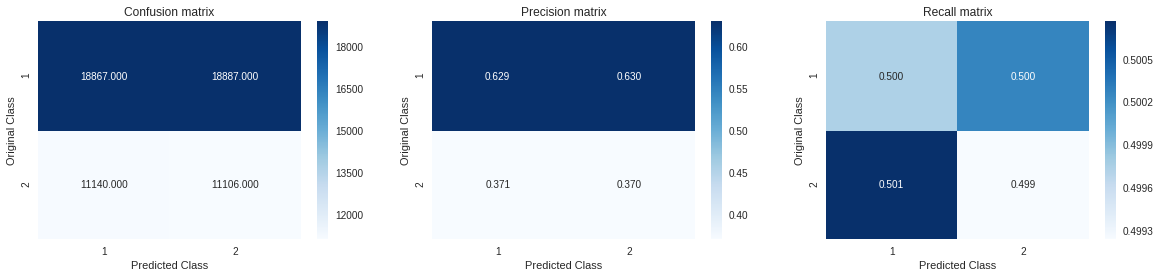

In [0]:
# we need to generate 9 numbers and the sum of numbers should be 1
# one solution is to genarate 9 numbers and divide each of the numbers by their sum
# ref: https://stackoverflow.com/a/18662466/4084039
# we create a output array that has exactly same size as the CV data
predicted_y = np.zeros((test_len,2))
for i in range(test_len):
    rand_probs = np.random.rand(1,2)
    predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Test Data using Random Model",log_loss(y_test_tfidf_w2v, predicted_y, eps=1e-15))

predicted_y =np.argmax(predicted_y, axis=1)
plot_confusion_matrix(y_test_tfidf_w2v, predicted_y)

<h2> 5.2 Logistic Regression (TFIDF Vectors)with hyperparameter tuning </h2>

For values of alpha =  1e-05 The log loss is: 0.6609766180741463
For values of alpha =  0.0001 The log loss is: 0.6604643102219836
For values of alpha =  0.001 The log loss is: 0.6602628135138089
For values of alpha =  0.01 The log loss is: 0.660648928391186
For values of alpha =  0.1 The log loss is: 0.6611708102152325
For values of alpha =  1 The log loss is: 0.6612346566389918
For values of alpha =  10 The log loss is: 0.6612340442079255


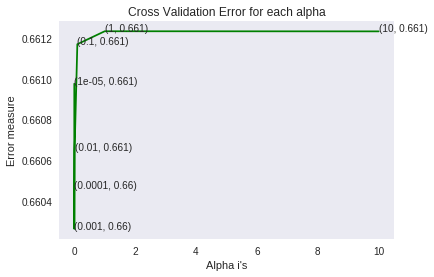

For values of best alpha =  0.001 The train log loss is: 0.6586054157676847
For values of best alpha =  0.001 The test log loss is: 0.6602628135138089
Total number of data points : 60000


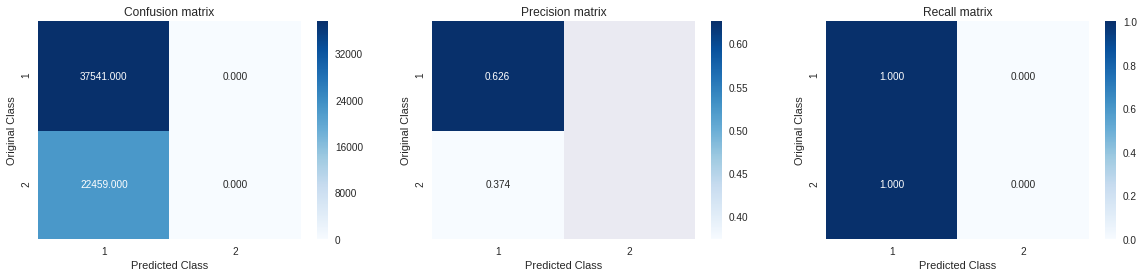

In [0]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: 
#------------------------------


log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(result_tfidf_train, y_train_tfidf)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(result_tfidf_train, y_train_tfidf)
    predict_y = sig_clf.predict_proba(result_tfidf_test)
    log_error_array.append(log_loss(y_test_tfidf, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test_tfidf, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(result_tfidf_train, y_train_tfidf)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(result_tfidf_train, y_train_tfidf)

predict_y = sig_clf.predict_proba(result_tfidf_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train_tfidf, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(result_tfidf_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test_tfidf, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test_tfidf, predicted_y)

<h2> 5.2 Logistic Regression (TFIDF W2V Vectors)with hyperparameter tuning </h2>

For values of alpha =  1e-05 The log loss is: 0.6593738015479585
For values of alpha =  0.0001 The log loss is: 0.6593738015479585
For values of alpha =  0.001 The log loss is: 0.6593696313855798
For values of alpha =  0.01 The log loss is: 0.6593763674085321
For values of alpha =  0.1 The log loss is: 0.6593765392587707
For values of alpha =  1 The log loss is: 0.6593770281795195
For values of alpha =  10 The log loss is: 0.6593872617398684


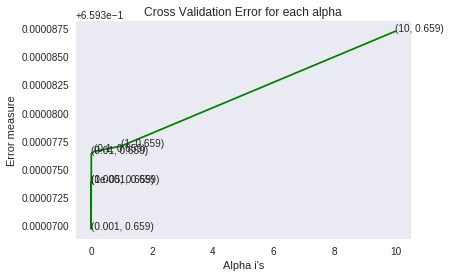

For values of best alpha =  0.001 The train log loss is: 0.6597757192939351
For values of best alpha =  0.001 The test log loss is: 0.6612123705356522
Total number of data points : 60000


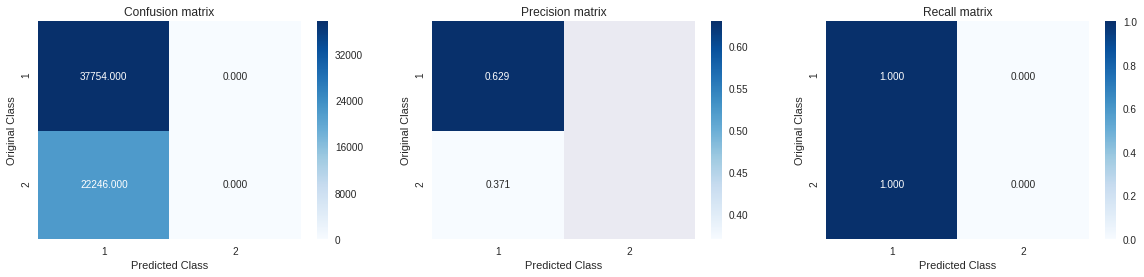

In [0]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: 
#------------------------------


log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(result_tfidf_w2v_train, y_train_tfidf_w2v)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(result_tfidf_w2v_train, y_train_tfidf_w2v)
    predict_y = sig_clf.predict_proba(result_tfidf_w2v_test)
    log_error_array.append(log_loss(y_test_tfidf_w2v, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test_tfidf_w2v, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(result_tfidf_w2v_train, y_train_tfidf_w2v)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(result_tfidf_w2v_train, y_train_tfidf_w2v)

predict_y = sig_clf.predict_proba(result_tfidf_w2v_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train_tfidf, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(result_tfidf_w2v_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test_tfidf, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test_tfidf_w2v, predicted_y)

<h2> 5.3 Linear SVM (TFIDF Vectors) with hyperparameter tuning </h2>

For values of alpha =  1e-05 The log loss is: 0.640481929129203
For values of alpha =  0.0001 The log loss is: 0.6343522077362349
For values of alpha =  0.001 The log loss is: 0.6429948382263273
For values of alpha =  0.01 The log loss is: 0.6612303311208646
For values of alpha =  0.1 The log loss is: 0.6612327173665996
For values of alpha =  1 The log loss is: 0.6612318538312896
For values of alpha =  10 The log loss is: 0.6612284889362576


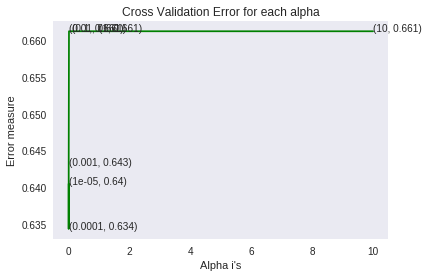

For values of best alpha =  0.0001 The train log loss is: 0.6315257580221483
For values of best alpha =  0.0001 The test log loss is: 0.6343522077362349
Total number of data points : 60000


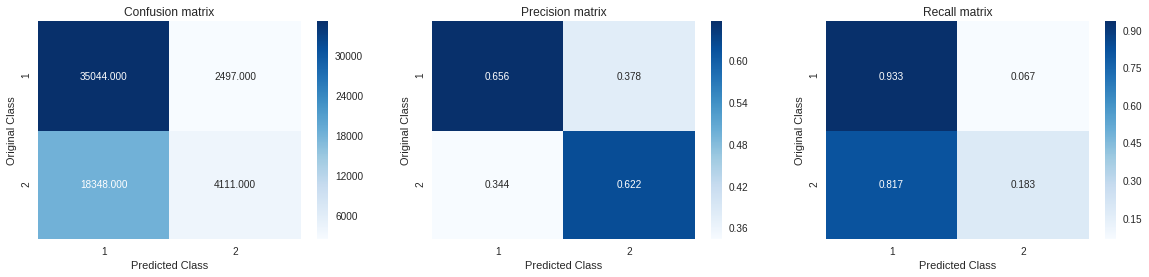

In [0]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: 
#------------------------------


log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l1', loss='hinge', random_state=42)
    clf.fit(result_tfidf_train, y_train_tfidf)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(result_tfidf_train, y_train_tfidf)
    predict_y = sig_clf.predict_proba(result_tfidf_test)
    log_error_array.append(log_loss(y_test_tfidf, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test_tfidf, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l1', loss='hinge', random_state=42)
clf.fit(result_tfidf_train, y_train_tfidf)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(result_tfidf_train, y_train_tfidf)

predict_y = sig_clf.predict_proba(result_tfidf_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train_tfidf, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(result_tfidf_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test_tfidf, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test_tfidf, predicted_y)

<h2> 5.3 Linear SVM (TFIDF W2V Vectors) with hyperparameter tuning </h2>

For values of alpha =  1e-05 The log loss is: 0.6593738015479585
For values of alpha =  0.0001 The log loss is: 0.6593738015479585
For values of alpha =  0.001 The log loss is: 0.6593656996272349
For values of alpha =  0.01 The log loss is: 0.6593738015479585
For values of alpha =  0.1 The log loss is: 0.6593738015479585
For values of alpha =  1 The log loss is: 0.6593745098935841
For values of alpha =  10 The log loss is: 0.6593732982636832


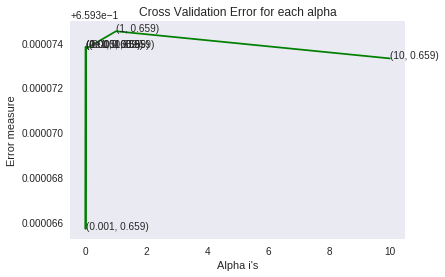

For values of best alpha =  0.001 The train log loss is: 0.6605951623182249
For values of best alpha =  0.001 The test log loss is: 0.6593656996272349
Total number of data points : 60000


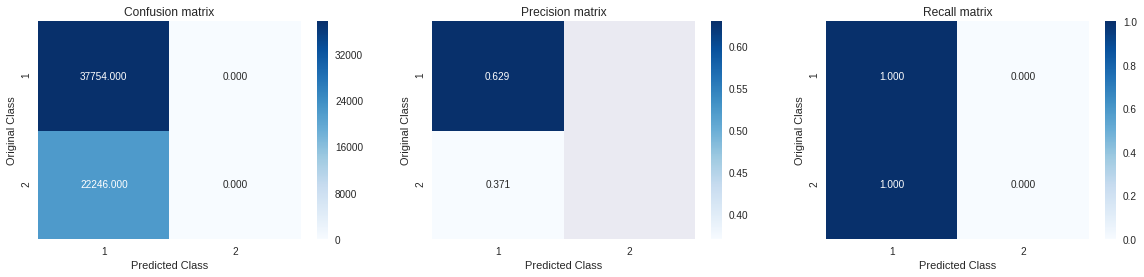

In [0]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: 
#------------------------------


log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l1', loss='hinge', random_state=42)
    clf.fit(result_tfidf_w2v_train, y_train_tfidf_w2v)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(result_tfidf_w2v_train, y_train_tfidf_w2v)
    predict_y = sig_clf.predict_proba(result_tfidf_w2v_test)
    log_error_array.append(log_loss(y_test_tfidf_w2v, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test_tfidf_w2v, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l1', loss='hinge', random_state=42)
clf.fit(result_tfidf_w2v_train, y_train_tfidf_w2v)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(result_tfidf_w2v_train, y_train_tfidf_w2v)

predict_y = sig_clf.predict_proba(result_tfidf_w2v_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train_tfidf_w2v, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(result_tfidf_w2v_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test_tfidf_w2v, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test_tfidf_w2v, predicted_y)

<h2> 5.4 XGBoost Model(TFIDF weighted word-**vectors**)  </h2>

In [0]:
import xgboost as xgb
params = {}
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'logloss'
params['eta'] = 0.02
params['max_depth'] = 4

d_train = xgb.DMatrix(result_tfidf_w2v_train, label=y_train_tfidf_w2v)
d_test = xgb.DMatrix(result_tfidf_w2v_test, label=y_test_tfidf_w2v)

watchlist = [(d_train, 'train'), (d_test, 'valid')]

bst = xgb.train(params, d_train, 400, watchlist, early_stopping_rounds=20, verbose_eval=10)

xgdmat = xgb.DMatrix(result_tfidf_w2v_train,y_train_tfidf_w2v)
predict_y = bst.predict(d_test)
print("The test log loss is:",log_loss(y_test_tfidf_w2v, predict_y, labels=clf.classes_, eps=1e-15))

[0]	train-logloss:0.691843	valid-logloss:0.691849
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 20 rounds.
[10]	train-logloss:0.681302	valid-logloss:0.681363
[20]	train-logloss:0.674185	valid-logloss:0.674286
[30]	train-logloss:0.669327	valid-logloss:0.669525
[40]	train-logloss:0.665943	valid-logloss:0.666316
[50]	train-logloss:0.66358	valid-logloss:0.664139
[60]	train-logloss:0.661909	valid-logloss:0.662658
[70]	train-logloss:0.660682	valid-logloss:0.661662
[80]	train-logloss:0.65977	valid-logloss:0.660993
[90]	train-logloss:0.659068	valid-logloss:0.660538
[100]	train-logloss:0.65851	valid-logloss:0.660233
[110]	train-logloss:0.658044	valid-logloss:0.660031
[120]	train-logloss:0.657679	valid-logloss:0.659905
[130]	train-logloss:0.657276	valid-logloss:0.659809
[140]	train-logloss:0.656977	valid-logloss:0.659747
[150]	train-logloss:0.656638	valid-logloss:0.6597
[160]	train-logloss:0.656352	vali

Total number of data points : 60000


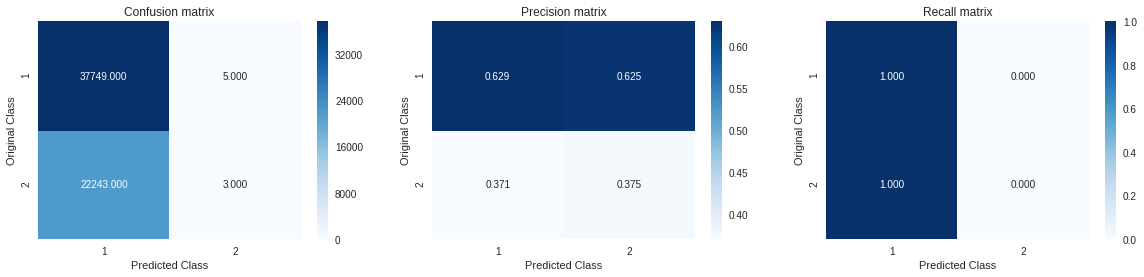

In [0]:
predicted_y =np.array(predict_y>0.5,dtype=int)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test_tfidf_w2v, predicted_y)

<h2> 5.4 XGBoost Model(TFIDF weighted word-**vectors**) with hyperparameter tuning  </h2>

In [0]:
from sklearn.model_selection import RandomizedSearchCV



start = dt.datetime.now()

params_fixed={
'objective':'binary:logistic',
'eval_metric':'logloss',
'silent': 1,
'nthread':-1}


params ={'max_depth':[1,2,3,4,5],
'n_estimators' : [100, 300, 500, 700, 900, 1000,1100],
'learning_rate' : [0.0001, 0.001, 0.01, 0.1,1,10],
'subsample' : [0.1,0.3,0.5,0.7,0.9,1],
'colsample_bytree' : [0.1, 0.3, 0.5, 0.7 , 0.9, 1]}

rs_grid =RandomizedSearchCV(
     estimator =XGBClassifier(**params_fixed),
     param_distributions=params,
     n_jobs=-1) 

print((result_tfidf_w2v_train.shape))
print((y_train_tfidf_w2v.shape))
rs_grid.fit(result_tfidf_w2v_train.iloc[:70000,:], y_train_tfidf_w2v.iloc[:70000])

rs_grid.cv_results_
print("\nTime Taken: ",dt.datetime.now() - start)

(140000, 626)
(140000,)

Time Taken:  2:35:54.982501


In [0]:
rs_grid.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.7, eval_metric='logloss', gamma=0,
       learning_rate=0.0001, max_delta_step=0, max_depth=2,
       min_child_weight=1, missing=None, n_estimators=500, n_jobs=1,
       nthread=-1, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None, silent=1,
       subsample=0.3)

In [0]:
rs_grid.best_params_

{'colsample_bytree': 0.7,
 'learning_rate': 0.0001,
 'max_depth': 2,
 'n_estimators': 500,
 'subsample': 0.3}

In [0]:
rs_grid.best_score_

0.6282428571428571

In [0]:
params = {}
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'logloss'
params['eta'] = 0.02
params['max_depth'] = 2
params['silent'] = 1
params['n_estimators'] =500
params['learning_rate'] = 0.0001
params['subsample'] = 0.3
params['colsample_bytree'] = 0.7


d_train = xgb.DMatrix(result_tfidf_w2v_train, label=y_train_tfidf_w2v)
d_test = xgb.DMatrix(result_tfidf_w2v_test, label=y_test_tfidf_w2v)

watchlist = [(d_train, 'train'), (d_test, 'valid')]

bst = xgb.train(params, d_train, 400, watchlist,verbose_eval= 10,early_stopping_rounds=20)

xgdmat = xgb.DMatrix(result_tfidf_w2v_train,y_train_tfidf_w2v)
predict_y = bst.predict(d_test)
print("The test log loss is:",log_loss(y_test_tfidf_w2v, predict_y, labels=clf.classes_, eps=1e-15))

[0]	train-logloss:0.693141	valid-logloss:0.693141
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 20 rounds.
[10]	train-logloss:0.693076	valid-logloss:0.693075
[20]	train-logloss:0.693011	valid-logloss:0.693009
[30]	train-logloss:0.692947	valid-logloss:0.692944
[40]	train-logloss:0.692882	valid-logloss:0.692879
[50]	train-logloss:0.692818	valid-logloss:0.692814
[60]	train-logloss:0.692754	valid-logloss:0.692749
[70]	train-logloss:0.692691	valid-logloss:0.692684
[80]	train-logloss:0.692626	valid-logloss:0.692619
[90]	train-logloss:0.692563	valid-logloss:0.692555
[100]	train-logloss:0.692499	valid-logloss:0.69249
[110]	train-logloss:0.692435	valid-logloss:0.692425
[120]	train-logloss:0.692371	valid-logloss:0.692361
[130]	train-logloss:0.692308	valid-logloss:0.692297
[140]	train-logloss:0.692245	valid-logloss:0.692233
[150]	train-logloss:0.692182	valid-logloss:0.692169
[160]	train-logloss:0.69212	v

Total number of data points : 60000


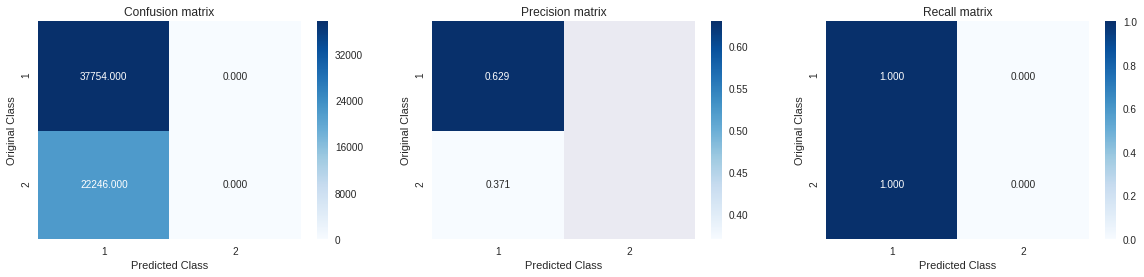

In [0]:
predicted_y =np.array(predict_y>0.5,dtype=int)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test_tfidf_w2v, predicted_y)

<h1>4. Featurizing text data with tfidf weighted word-vectors </h1>

In [0]:
# avoid decoding problems
df = pd.read_csv("/content/drive/My Drive/Quora/train.csv")

# encode questions to unicode
# https://stackoverflow.com/a/6812069
# ----------------- python 2 ---------------------
# df['question1'] = df['question1'].apply(lambda x: unicode(str(x),"utf-8"))
# df['question2'] = df['question2'].apply(lambda x: unicode(str(x),"utf-8"))

df['question1'] = df['question1'].apply(lambda x: str(x))
df['question2'] = df['question2'].apply(lambda x: str(x))

In [0]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [0]:
#Balancing dataset
df = df.sort_values(by=['is_duplicate'])
df1_pos =df.iloc[:100000,:]
df2_neg =df.iloc[-100000:,:]
df_ = df1_pos.append(df2_neg, ignore_index=True)
data = df_.iloc[0:200000,:]# taking the first 2 lak reviews


print('~> Question pairs are not Similar (is_duplicate = 0):\n   {}%'.format(100 - round(data['is_duplicate'].mean()*100, 2)))
print('\n~> Question pairs are Similar (is_duplicate = 1):\n   {}%'.format(round(data['is_duplicate'].mean()*100, 2)))

y_true = data['is_duplicate']
data.drop(['is_duplicate'], axis=1, inplace=True)


#train test split
X_train_tfidf_w2v,X_test_tfidf_w2v, y_train_tfidf_w2v, y_test_tfidf_w2v, = train_test_split(data,y_true, test_size=0.3)
X_train_tfidf,X_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(data,y_true, test_size=0.3)

~> Question pairs are not Similar (is_duplicate = 0):
   50.0%

~> Question pairs are Similar (is_duplicate = 1):
   50.0%


In [0]:
print(data.head())

       id    qid1    qid2                                          question1  \
0       0       1       2  What is the step by step guide to invest in sh...   
1  239788  351460  351461                             South Indian cookbook?   
2  239787  213043  122890                           Why do you not have sex?   
3  239786  351458  351459  Scooby-Doo: What are some reasons that the "Sh...   
4  239785  351456  351457  How would one bring gaming to television as a ...   

                                           question2  
0  What is the step by step guide to invest in sh...  
1  Do porn actors not mind that their movies migh...  
2                            Why do people have sex?  
3        Why do villains in Scooby-Doo get arrested?  
4        What is a good gaming news YouTube channel?  


In [0]:
# merge texts
questions_train = list(X_train_tfidf_w2v['question1']) + list(X_train_tfidf_w2v['question2'])
questions_test = list(X_test_tfidf_w2v['question1']) + list(X_test_tfidf_w2v['question2'])

tfidf = TfidfVectorizer(lowercase=False, )
tfidf.fit_transform(questions_train)
tfidf.transform(questions_test)

# dict key:word and value:tf-idf score
word2tfidf = dict(zip(tfidf.get_feature_names(), tfidf.idf_))

In [0]:
print(len(word2tfidf))

62169


In [0]:
print(type(X_test_tfidf_w2v['question1']))

<class 'pandas.core.series.Series'>


In [0]:
!python3 -m spacy download en_core_web_lg

    100% |████████████████████████████████| 852.3MB 38.8MB/s 
  Running setup.py install for en-core-web-lg ... done

    Linking successful
    /usr/local/lib/python3.6/dist-packages/en_core_web_lg -->
    /usr/local/lib/python3.6/dist-packages/spacy/data/en_core_web_lg

    You can now load the model via spacy.load('en_core_web_lg')



- After we find TF-IDF scores, we convert each question to a weighted average of word2vec vectors by these scores.
- here we use a pre-trained GLOVE model which comes free with "Spacy".  https://spacy.io/usage/vectors-similarity
- It is trained on Wikipedia and therefore, it is stronger in terms of word semantics. 

In [0]:
# en_vectors_web_lg, which includes over 1 million unique vectors.
nlp = spacy.load('en_core_web_lg')

def tfidf_w2v_model(list_of_sent): 
  vecs1 = []
  # https://github.com/noamraph/tqdm
  # tqdm is used to print the progress bar
  for qu1 in tqdm(list(list_of_sent)):
      doc1 = nlp(qu1) 
      # 384 is the number of dimensions of vectors 
      mean_vec1 = np.zeros([len(doc1), 300])
      for word1 in doc1:
          # word2vec
          vec1 = word1.vector
          # fetch df score
          try:
              idf = word2tfidf[str(word1)]
          except:
              idf = 0
          # compute final vec
          mean_vec1 += vec1 * idf
      mean_vec1 = mean_vec1.mean(axis=0)
      vecs1.append(mean_vec1)
  return list(vecs1)

X_train_tfidf_w2v['q1_feats_m'] =tfidf_w2v_model(X_train_tfidf_w2v['question1'])
X_train_tfidf_w2v['q2_feats_m'] =tfidf_w2v_model(X_train_tfidf_w2v['question2'])

X_test_tfidf_w2v['q1_feats_m'] =tfidf_w2v_model(X_test_tfidf_w2v['question1'])
X_test_tfidf_w2v['q2_feats_m'] =tfidf_w2v_model(X_test_tfidf_w2v['question2'])

100%|██████████| 60000/60000 [20:54<00:00, 47.49it/s]


In [0]:
#prepro_features_train.csv (Simple Preprocessing Feartures)
#nlp_features_train.csv (NLP Features)
if os.path.isfile('/content/drive/My Drive/quora/nlp_features_train.csv'):
    dfnlp = pd.read_csv("/content/drive/My Drive/quora/nlp_features_train.csv",encoding='latin-1')
else:
    print("download nlp_features_train.csv from drive or run previous notebook")

if os.path.isfile('/content/drive/My Drive/quora/df_fe_without_preprocessing_train.csv'):
    dfppro = pd.read_csv("/content/drive/My Drive/quora/df_fe_without_preprocessing_train.csv",encoding='latin-1')
else:
    print("download df_fe_without_preprocessing_train.csv from drive or run previous notebook")

In [0]:
df1 = dfnlp.drop(['qid1','qid2','question1','question2','is_duplicate'],axis=1)
df2 = dfppro.drop(['qid1','qid2','question1','question2','is_duplicate'],axis=1)
df3_train = X_train_tfidf_w2v.drop(['qid1','qid2','question1','question2'],axis=1)
df3_test = X_test_tfidf_w2v.drop(['qid1','qid2','question1','question2'],axis=1)
df3_q1_train = pd.DataFrame(df3_train.q1_feats_m.values.tolist(), index= df3_train.index)
df3_q2_train = pd.DataFrame(df3_train.q2_feats_m.values.tolist(), index= df3_train.index)
df3_q1_test = pd.DataFrame(df3_test.q1_feats_m.values.tolist(), index= df3_test.index)
df3_q2_test = pd.DataFrame(df3_test.q2_feats_m.values.tolist(), index= df3_test.index)

In [0]:
# dataframe of nlp features
print(df1.shape)
df1.head()

(404290, 16)


,id,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
0,0,0.999980,0.833319,0.999983,0.999983,0.916659,0.785709,0.0,1.0,2.0,13.0,100,93,93,100,0.982759
1,1,0.799984,0.399996,0.749981,0.599988,0.699993,0.466664,0.0,1.0,5.0,12.5,86,63,66,75,0.596154
2,2,0.399992,0.333328,0.399992,0.249997,0.399996,0.285712,0.0,1.0,4.0,12.0,63,63,43,47,0.166667
3,3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,2.0,12.0,28,24,9,14,0.039216
4,4,0.399992,0.199998,0.999950,0.666644,0.571420,0.307690,0.0,1.0,6.0,10.0,67,47,35,56,0.175000


In [0]:
# data before preprocessing 
print(df2.shape)
df2.head()

(404290, 12)


,id,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
0,0,1,1,66,57,14,12,10.0,23.0,0.434783,2,0
1,1,4,1,51,88,8,13,4.0,20.0,0.200000,5,3
2,2,1,1,73,59,14,10,4.0,24.0,0.166667,2,0
3,3,1,1,50,65,11,9,0.0,19.0,0.000000,2,0
4,4,3,1,76,39,13,7,2.0,20.0,0.100000,4,2


In [0]:
# Questions 1 tfidf weighted word2vec
print(df3_q1_train.shape)
df3_q1_train.head()

(140000, 300)


,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
135318,3.785521,-2.458576,-7.141168,-3.478820,22.231709,-0.485751,-1.922564,2.012616,8.702049,88.833314,...,-1.814542,-2.952653,-2.797538,-3.639615,1.100580,-5.795601,-1.243595,-6.566241,1.253269,7.059631
165182,-7.625721,9.371722,7.799777,-3.707324,11.565776,-9.493443,-3.541967,-6.400735,9.781337,128.084848,...,-15.287800,4.606821,10.749875,-10.081720,6.978358,2.500397,-8.802123,-18.732966,8.759437,11.834048
100221,-2.634218,7.035779,-0.986726,-7.596651,4.037613,-2.509742,-0.186922,-3.316449,0.760204,56.533471,...,-16.790042,3.369634,1.591434,6.963246,5.394429,-0.105949,-8.972886,-1.315816,-3.509817,7.699788
61232,7.477033,3.300084,-3.947741,-1.781588,3.553411,-0.112312,-3.348448,-2.137044,1.109899,80.275700,...,3.118421,0.622916,-1.254393,-1.568608,1.614502,2.225088,-4.229224,-1.157396,6.005407,-1.911030
8340,8.349623,-12.675297,8.157660,-18.336337,12.759494,4.340609,-0.197798,-4.032299,11.665017,220.260420,...,22.046394,13.092176,3.019090,8.510152,23.449564,-14.410397,5.630946,-3.149661,-3.523648,15.922268


In [0]:
# Questions 2 tfidf weighted word2vec
print(df3_q2_train.shape)
df3_q2_train.head()

(140000, 300)


,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
135318,4.914796,-0.449396,-10.591570,-4.894606,21.554054,-2.105943,-2.068768,0.065834,9.009754,103.932213,...,1.737920,0.234290,-5.579682,-4.729650,5.292368,-2.257787,-4.120495,-4.508256,1.582616,8.321256
165182,-8.272624,6.748367,4.177312,-3.509934,9.169178,-8.465279,-3.367628,-6.026127,7.836393,126.818764,...,-17.210705,5.747104,9.601519,-9.075239,7.258039,3.795285,-7.804396,-16.846247,9.550503,12.178659
100221,-2.009951,4.360422,-0.489114,-5.627995,5.481587,-4.436085,-1.379906,-2.119410,1.173666,44.854867,...,-15.412151,3.805903,1.193210,9.048926,5.224221,-1.219203,-11.135658,-2.016894,-3.744599,9.936589
61232,5.246078,4.096689,-1.892017,0.539205,4.084612,1.250446,-3.634248,-1.938902,1.832799,90.197890,...,-1.913383,0.786183,-0.508733,-2.657914,2.962715,1.724648,-1.339521,-1.625459,4.450121,-0.063439
8340,-2.863263,0.816858,5.342234,-6.420203,5.681675,5.700663,9.810000,-12.214067,7.690685,52.899348,...,15.456469,2.548701,-0.816868,5.438041,2.585539,7.381948,-6.123382,-11.702206,-8.003842,9.027461


In [0]:
# Questions 1 tfidf weighted word2vec
print(df3_q1_test.shape)
df3_q1_test.head()

(60000, 300)


,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
99896,-3.093514,16.735412,-5.300599,20.361627,11.530718,-6.116789,-2.820214,-8.311967,7.128341,79.981472,...,-18.344266,-5.279740,4.666809,2.182663,-0.228538,2.123272,4.372244,4.597380,1.538466,-0.319077
5774,-10.439962,9.573012,6.730802,0.021181,-2.008417,2.634880,1.327743,-10.665709,7.326520,83.170987,...,-11.311565,1.618281,3.575034,-4.243310,-0.030855,-2.041907,-7.239204,5.076421,-3.289154,6.004695
89258,8.094546,7.235748,7.770236,2.202644,10.501996,-10.314131,-3.639927,-1.232261,-9.730206,76.032091,...,10.800092,12.781575,-4.979266,-7.332982,14.025370,4.670899,-6.665399,-5.685545,-5.142871,12.874417
61927,-23.219720,3.481902,-16.336188,2.335819,5.188461,10.170067,-11.887611,-4.318340,2.637240,220.387892,...,-14.074700,16.760632,-3.004216,-12.708856,14.427478,16.552427,-22.856259,-0.210550,-2.834050,21.979673
149690,-12.598411,9.729030,-11.429607,4.262534,-4.041768,2.286919,4.485741,13.260789,4.522374,135.433108,...,-13.703753,12.345375,-4.920293,-8.562103,4.629494,12.730818,-15.553985,10.581088,-3.491540,-5.446730


In [0]:
# Questions 2 tfidf weighted word2vec
print(df3_q2_test.shape)
df3_q2_test.head()

(60000, 300)


,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
99896,10.366590,28.068710,-2.436075,12.203517,7.314155,-29.312570,-12.083559,-26.994097,-0.445551,245.761251,...,-73.698231,4.884156,3.328046,-3.160497,8.046748,-2.967936,6.683006,1.326857,4.808152,19.592364
5774,-12.959268,11.526116,9.129501,1.717329,-4.809479,1.035017,-0.594112,-13.928099,16.589655,133.660266,...,-19.946388,7.292653,0.652659,0.995015,-1.309297,-8.121811,-5.935696,3.900727,-7.388329,3.650571
89258,7.227227,1.542615,-6.569459,-0.377402,8.983694,-10.968503,0.782083,-0.574098,0.882699,102.979983,...,-0.704815,7.614030,1.695457,0.065612,1.950095,7.770542,-1.595119,-6.964003,-1.213854,7.574982
61927,-15.824446,-5.967149,1.479313,0.286221,1.808971,13.441908,-0.099194,1.909185,1.769612,49.966753,...,4.178988,-2.749143,-21.282978,-8.248929,-4.683441,6.208512,-3.494501,-10.260794,6.615281,2.640183
149690,-13.530049,8.858787,-10.871068,5.579123,-5.229896,1.366697,3.897109,14.198486,3.375104,118.055004,...,-13.491169,13.589904,-5.020951,-6.500589,5.237629,11.952527,-14.208678,10.017388,-2.914454,-7.281980


In [0]:
print("Number of features in nlp dataframe :", df1.shape[1])
print("Number of features in preprocessed dataframe :", df2.shape[1])
print("Number of features in question1 w2v  dataframe :", df3_q1_train.shape[1])
print("Number of features in question2 w2v  dataframe :", df3_q2_train.shape[1])
print("Number of features in final dataframe  :", df1.shape[1]+df2.shape[1]+df3_q1_train.shape[1]+df3_q2_train.shape[1])

Number of features in nlp dataframe : 16
Number of features in preprocessed dataframe : 12
Number of features in question1 w2v  dataframe : 300
Number of features in question2 w2v  dataframe : 300
Number of features in final dataframe  : 628


In [0]:
df3_train.head(20)

,id,q1_feats_m,q2_feats_m
135318,173453,"[3.7855214178562164, -2.458575591444969, -7.14...","[4.9147960767149925, -0.4493955224752426, -10...."
165182,304429,"[-7.625721409916878, 9.371722161769867, 7.7997...","[-8.27262381464243, 6.748367488384247, 4.17731..."
100221,356923,"[-2.634218357503414, 7.035778760910034, -0.986...","[-2.009950965642929, 4.360421895980835, -0.489..."
61232,204819,"[7.477032881230116, 3.300084173679352, -3.9477...","[5.24607751891017, 4.096689403057098, -1.89201..."
8340,243348,"[8.34962260723114, -12.675297170877457, 8.1576...","[-2.863262817263603, 0.8168577551841736, 5.342..."
33518,253563,"[2.913542566820979, 27.478071585297585, -19.13...","[17.432064544409513, 13.27016006410122, -11.76..."
88804,347639,"[-6.406554169952869, 3.25842846930027, -13.086...","[-14.77932769805193, 11.948445439338684, -15.9..."
65784,217211,"[-6.2743532955646515, 1.428545854985714, 8.239...","[-15.23708014190197, 16.829555325210094, 10.55..."
184325,107898,"[-24.479322962462902, 30.451885264366865, -15....","[-16.062571235001087, 16.147462412714958, -20...."
99548,396747,"[-5.754052571952343, -3.0749298948794603, -6.3...","[-2.239831231534481, -0.6782020181417465, -12...."


In [0]:
# storing the final features with tfidf weighted word - vectors to csv file

df3_q1_train['id'] = df3_train['id']
df3_q2_train['id']=df3_train['id']
df3_q1_test['id']=df3_test['id']
df3_q2_test['id']=df3_test['id']

print("df3_q1_train shape",df3_q1_train.shape)
print("df3_q1_test shape",df3_q1_test.shape)
print("df3_q2_train shape",df3_q2_train.shape)

print("df3_q2_test shape",df3_q2_test.shape)  

rows =df3_q1_train['id']!=df3_train['id']
print("Sanity check for index matching")
print (rows.any())

nan_rows = df1[df1.isnull().any(1)]
print("null rows of df1 dataframe before merge")
print (nan_rows)

df3_q1_train shape (140000, 301)
df3_q1_test shape (60000, 301)
df3_q2_train shape (140000, 301)
df3_q2_test shape (60000, 301)
Sanity check for index matching
False
null rows of df1 dataframe before merge
Empty DataFrame
Columns: [id, cwc_min, cwc_max, csc_min, csc_max, ctc_min, ctc_max, last_word_eq, first_word_eq, abs_len_diff, mean_len, token_set_ratio, token_sort_ratio, fuzz_ratio, fuzz_partial_ratio, longest_substr_ratio]
Index: []


In [0]:
df1  = df1.merge(df2, on='id',how='left')
print("df1 shape",df1.shape)

nan_rows = df1[df1.isnull().any(1)]
print("null rows of df1 dataframe after merge")
print (nan_rows)

df1 shape (404290, 27)
null rows of df1 dataframe after merge
Empty DataFrame
Columns: [id, cwc_min, cwc_max, csc_min, csc_max, ctc_min, ctc_max, last_word_eq, first_word_eq, abs_len_diff, mean_len, token_set_ratio, token_sort_ratio, fuzz_ratio, fuzz_partial_ratio, longest_substr_ratio, freq_qid1, freq_qid2, q1len, q2len, q1_n_words, q2_n_words, word_Common, word_Total, word_share, freq_q1+q2, freq_q1-q2]
Index: []

[0 rows x 27 columns]


In [0]:
df2_train  = df3_q1_train.merge(df3_q2_train, on='id',how='left')
df2_test  = df3_q1_test.merge(df3_q2_test, on='id',how='left')
print("df2_train shape",df2_train.shape)
print("df2_test shape",df2_test.shape)

df2_train shape (140000, 601)
df2_test shape (60000, 601)


In [0]:
print("df shape",df2.shape)
result_tfidf_w2v_test  = df1.merge(df2_test, on='id',how='right')

nan_rows = result_tfidf_w2v_test[result_tfidf_w2v_test.isnull().any(1)]
print("null rows of df1 dataframe after merge")
print (nan_rows)


print("result_tfidf_w2v_test shape", result_tfidf_w2v_test.shape)
#     result_tfidf_w2v_test.to_csv('/content/drive/My Drive/quora/result_tfidf_w2v_test.csv')

result_tfidf_w2v_train  = df1.merge(df2_train, on='id',how='right')

nan_rows = result_tfidf_w2v_train[result_tfidf_w2v_train.isnull().any(1)]
print("null rows of df1 dataframe after merge")
print (nan_rows)

print("result_tfidf_w2v_train shape",result_tfidf_w2v_train.shape)
#     result_tfidf_w2v_train.to_csv('/content/drive/My Drive/quora/result_tfidf_w2v_train.csv')


df shape (404290, 12)
null rows of df1 dataframe after merge
Empty DataFrame
Columns: [id, cwc_min, cwc_max, csc_min, csc_max, ctc_min, ctc_max, last_word_eq, first_word_eq, abs_len_diff, mean_len, token_set_ratio, token_sort_ratio, fuzz_ratio, fuzz_partial_ratio, longest_substr_ratio, freq_qid1, freq_qid2, q1len, q2len, q1_n_words, q2_n_words, word_Common, word_Total, word_share, freq_q1+q2, freq_q1-q2, 0_x, 1_x, 2_x, 3_x, 4_x, 5_x, 6_x, 7_x, 8_x, 9_x, 10_x, 11_x, 12_x, 13_x, 14_x, 15_x, 16_x, 17_x, 18_x, 19_x, 20_x, 21_x, 22_x, 23_x, 24_x, 25_x, 26_x, 27_x, 28_x, 29_x, 30_x, 31_x, 32_x, 33_x, 34_x, 35_x, 36_x, 37_x, 38_x, 39_x, 40_x, 41_x, 42_x, 43_x, 44_x, 45_x, 46_x, 47_x, 48_x, 49_x, 50_x, 51_x, 52_x, 53_x, 54_x, 55_x, 56_x, 57_x, 58_x, 59_x, 60_x, 61_x, 62_x, 63_x, 64_x, 65_x, 66_x, 67_x, 68_x, 69_x, 70_x, 71_x, 72_x, ...]
Index: []

[0 rows x 627 columns]
result_tfidf_w2v_test shape (60000, 627)
null rows of df1 dataframe after merge
Empty DataFrame
Columns: [id, cwc_min, cwc_ma

In [0]:
print(df3_train[df3_train['id']==173453])

            id                                         q1_feats_m  \
135318  173453  [3.7855214178562164, -2.458575591444969, -7.14...   

                                               q2_feats_m  
135318  [4.9147960767149925, -0.4493955224752426, -10....  


In [0]:
a=result_tfidf_w2v_train[result_tfidf_w2v_train['id']==173453]
print(a.iloc[:,27:30])
print(a.iloc[:,327:330])

            0_x       1_x       2_x
38984  3.785521 -2.458576 -7.141168
            0_y       1_y       2_y
38984  4.914796 -0.449396 -10.59157


As we can observe the vlues of df3_train tfidf_w2v is correctlty merged with id to  result_tfidf_w2v_train

In [0]:
#Droping the index feature
result_tfidf_w2v_train.drop(columns=['id'], inplace=True)
result_tfidf_w2v_test.drop(columns=['id'], inplace=True)
result_tfidf_w2v_train.head()
#saving vecto to csv
# result_tfidf_w2v_train.to_csv('/content/drive/My Drive/quora/result_tfidf_w2v_train.csv')
# result_tfidf_w2v_test.to_csv('/content/drive/My Drive/quora/result_tfidf_w2v_test.csv')

,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,...,290_y,291_y,292_y,293_y,294_y,295_y,296_y,297_y,298_y,299_y
0,0.999980,0.833319,0.999983,0.999983,0.916659,0.785709,0.0,1.0,2.0,13.0,...,-17.968781,7.269838,1.508112,-7.529334,0.559350,-11.887119,-11.315331,1.611463,3.758253,11.929289
1,0.999950,0.666644,0.749981,0.599988,0.833319,0.624992,0.0,1.0,2.0,7.0,...,5.973116,-0.175264,-2.250509,8.049096,5.270754,0.342290,5.884829,4.768821,5.827888,-8.449233
2,0.399992,0.399992,0.499992,0.230767,0.454541,0.249999,0.0,0.0,9.0,15.5,...,-28.054199,-7.352970,10.865919,0.872227,10.027917,-12.819318,-8.725489,-13.157964,17.172959,20.903276
3,0.499988,0.399992,0.000000,0.000000,0.249997,0.222220,0.0,0.0,1.0,8.5,...,-3.029145,-1.186309,-1.389301,-7.535103,-2.188543,0.393419,4.605747,-3.597576,4.739163,4.556011
4,0.666644,0.666644,0.499988,0.499988,0.571420,0.499994,0.0,1.0,1.0,7.5,...,-4.571387,5.073733,3.886529,-0.938215,5.230582,1.969562,3.689500,-2.133297,-0.364578,2.093734


In [0]:
print(result_tfidf_w2v_train.shape)
print(result_tfidf_w2v_test.shape)

(140000, 626)
(60000, 626)


## 4.1. Featurizing text data with tfidf

In [0]:
tfidf = TfidfVectorizer(lowercase=False,)
tfidf_q1_train = tfidf.fit_transform(X_train_tfidf['question1'])
tfidf_q1_test  = tfidf.transform(X_test_tfidf['question1'])

tfidf1 = TfidfVectorizer(lowercase=False,)
tfidf_q2_train = tfidf1.fit_transform(X_train_tfidf['question2'])
tfidf_q2_test = tfidf1.transform(X_test_tfidf['question2'])

In [0]:
print(type(tfidf_q1_train))
print(type(tfidf_q2_train))

<class 'scipy.sparse.csr.csr_matrix'>
<class 'scipy.sparse.csr.csr_matrix'>


In [0]:
print("{0} shape of Q1".format((tfidf_q1_train.shape)))
print("{0} shape of Q2".format((tfidf_q2_train.shape)))

(140000, 51731) shape of Q1
(140000, 47887) shape of Q2


In [0]:
#merge Q1 and Q2 tfidf vectors
import scipy
tfidf_q1_q2_train = scipy.sparse.hstack((tfidf_q1_train,tfidf_q2_train))
tfidf_q1_q2_test = scipy.sparse.hstack((tfidf_q1_test,tfidf_q2_test))
print(type(tfidf_q1_q2_train))
print(type(tfidf_q1_q2_test))
print(tfidf_q1_q2_train.shape)
print(tfidf_q1_q2_test.shape)

<class 'scipy.sparse.coo.coo_matrix'>
<class 'scipy.sparse.coo.coo_matrix'>
(140000, 99618)
(60000, 99618)


In [0]:
# After train test spit (random shufling) saving the index order to merge tfidf vectors with the fuzy and normal features

df3_train = X_train_tfidf.drop(['qid1','qid2','question1','question2'],axis=1)
df3_test = X_test_tfidf.drop(['qid1','qid2','question1','question2'],axis=1)
print("df3_train shape",df3_train.shape)
print("df3_test shape",df3_train.shape)



df_idx_train_tfidf = pd.DataFrame(df3_train['id'],columns = ['id'])
df_idx_test_tfidf = pd.DataFrame(df3_test['id'],columns = ['id'])
print(df_idx_train_tfidf.head())
print(df_idx_train_tfidf.shape)
print(df_idx_test_tfidf.head())
print(df_idx_test_tfidf.shape)

df3_train shape (140000, 1)
df3_test shape (140000, 1)
            id
182834  182834
142183  142183
132971  132971
54270    54270
10627    10627
(140000, 1)
            id
129308  129308
158883  158883
171555  171555
168352  168352
159687  159687
(60000, 1)


In [0]:
# storing the final features with tfidf weighted word - vectors to csv file
#Merging with the indexes of tfidf vectors
print("shape of df1",df1.shape)
nan_rows = df1[df1.isnull().any(1)]
print("null rows of df1 dataframe")
print (nan_rows)

shape of df1 (404290, 27)
null rows of df1 dataframe
Empty DataFrame
Columns: [id, cwc_min, cwc_max, csc_min, csc_max, ctc_min, ctc_max, last_word_eq, first_word_eq, abs_len_diff, mean_len, token_set_ratio, token_sort_ratio, fuzz_ratio, fuzz_partial_ratio, longest_substr_ratio, freq_qid1, freq_qid2, q1len, q2len, q1_n_words, q2_n_words, word_Common, word_Total, word_share, freq_q1+q2, freq_q1-q2]
Index: []

[0 rows x 27 columns]


In [0]:
df2_train  = df1.merge(df_idx_train_tfidf, on='id',how='right')
df2_test  = df1.merge(df_idx_test_tfidf, on='id',how='right')
nan_rows = df2_train[df2_train.isnull().any(1)]
print("null rows of df2_train dataframe")
print (nan_rows)
nan_rows = df2_test[df2_test.isnull().any(1)]
print("null rows of df2_test dataframe")
print (nan_rows)


print("shape of basic + advance features train",df2_train.shape)
print("shape of basic + advance features test",df2_test.shape)


null rows of df2_train dataframe
Empty DataFrame
Columns: [id, cwc_min, cwc_max, csc_min, csc_max, ctc_min, ctc_max, last_word_eq, first_word_eq, abs_len_diff, mean_len, token_set_ratio, token_sort_ratio, fuzz_ratio, fuzz_partial_ratio, longest_substr_ratio, freq_qid1, freq_qid2, q1len, q2len, q1_n_words, q2_n_words, word_Common, word_Total, word_share, freq_q1+q2, freq_q1-q2]
Index: []

[0 rows x 27 columns]
null rows of df2_test dataframe
Empty DataFrame
Columns: [id, cwc_min, cwc_max, csc_min, csc_max, ctc_min, ctc_max, last_word_eq, first_word_eq, abs_len_diff, mean_len, token_set_ratio, token_sort_ratio, fuzz_ratio, fuzz_partial_ratio, longest_substr_ratio, freq_qid1, freq_qid2, q1len, q2len, q1_n_words, q2_n_words, word_Common, word_Total, word_share, freq_q1+q2, freq_q1-q2]
Index: []

[0 rows x 27 columns]
shape of basic + advance features train (140000, 27)
shape of basic + advance features test (60000, 27)


In [0]:
#Droping the index feature
df2_train.drop(columns=['id'], inplace=True)
df2_test.drop(columns=['id'], inplace=True)

#converting dataframe to numpy array
df2_train = df2_train.values
df2_test = df2_test.values

#merging all features together
result_tfidf_train = scipy.sparse.hstack((df2_train,tfidf_q1_q2_train))
result_tfidf_test = scipy.sparse.hstack((df2_test,tfidf_q1_q2_test))

In [0]:
#final shape
print(result_tfidf_train.shape)
print(result_tfidf_test.shape)
print(type(result_tfidf_train))
print(type(result_tfidf_test))

(140000, 99644)
(60000, 99644)
<class 'scipy.sparse.coo.coo_matrix'>
<class 'scipy.sparse.coo.coo_matrix'>


<br/>
<br/>

In [0]:
print("-"*10, "Distribution of output variable in train data", "-"*10)
train_distr = Counter(y_train_tfidf_w2v)
train_len = len(y_train_tfidf_w2v)
print("Class 0: ",int(train_distr[0])/train_len,"Class 1: ", int(train_distr[1])/train_len)
print("-"*10, "Distribution of output variable in train data", "-"*10)
test_distr = Counter(y_test_tfidf_w2v)
test_len = len(y_test_tfidf_w2v)
print("Class 0: ",int(test_distr[1])/test_len, "Class 1: ",int(test_distr[1])/test_len)

---------- Distribution of output variable in train data ----------
Class 0:  0.4990428571428571 Class 1:  0.5009571428571429
---------- Distribution of output variable in train data ----------
Class 0:  0.4977666666666667 Class 1:  0.4977666666666667


In [0]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    plt.figure(figsize=(20,4))
    
    labels = [1,2]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True,cmap='Blues' , fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True,cmap='Blues', fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True,cmap='Blues', fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

<h2> 5.1 Building a random model (Finding worst-case log-loss) </h2>

Log loss on Test Data using Random Model 0.883327845913505


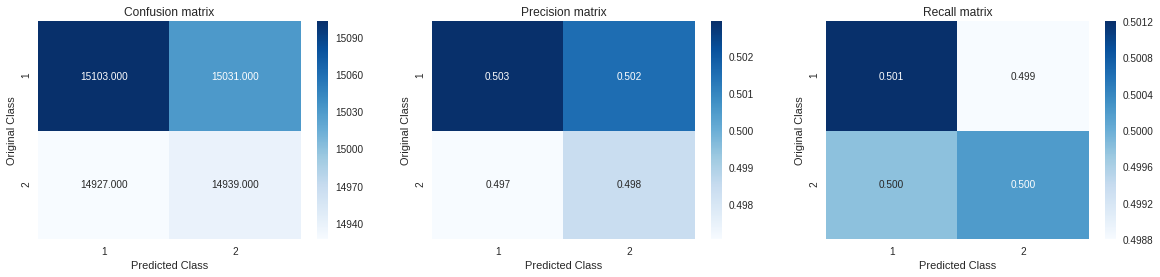

In [0]:
# we need to generate 9 numbers and the sum of numbers should be 1
# one solution is to genarate 9 numbers and divide each of the numbers by their sum
# ref: https://stackoverflow.com/a/18662466/4084039
# we create a output array that has exactly same size as the CV data
predicted_y = np.zeros((test_len,2))
for i in range(test_len):
    rand_probs = np.random.rand(1,2)
    predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Test Data using Random Model",log_loss(y_test_tfidf_w2v, predicted_y, eps=1e-15))

predicted_y =np.argmax(predicted_y, axis=1)
plot_confusion_matrix(y_test_tfidf_w2v, predicted_y)

<h2> 5.2 Logistic Regression (TFIDF Vectors)with hyperparameter tuning </h2>

For values of alpha =  1e-05 The log loss is: 0.6609766180741463
For values of alpha =  0.0001 The log loss is: 0.6604643102219836
For values of alpha =  0.001 The log loss is: 0.6602628135138089
For values of alpha =  0.01 The log loss is: 0.660648928391186
For values of alpha =  0.1 The log loss is: 0.6611708102152325
For values of alpha =  1 The log loss is: 0.6612346566389918
For values of alpha =  10 The log loss is: 0.6612340442079255


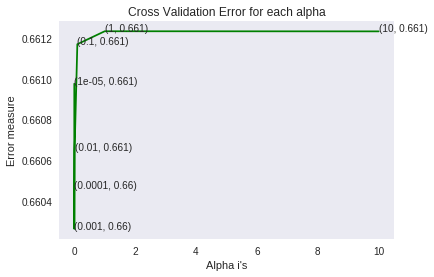

For values of best alpha =  0.001 The train log loss is: 0.6586054157676847
For values of best alpha =  0.001 The test log loss is: 0.6602628135138089
Total number of data points : 60000


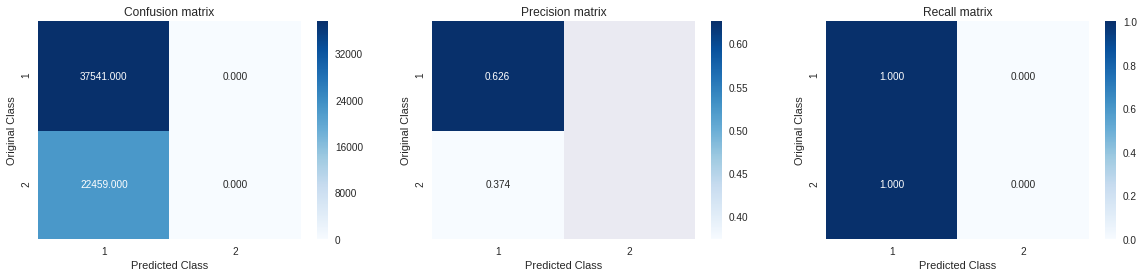

In [0]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: 
#------------------------------


log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(result_tfidf_train, y_train_tfidf)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(result_tfidf_train, y_train_tfidf)
    predict_y = sig_clf.predict_proba(result_tfidf_test)
    log_error_array.append(log_loss(y_test_tfidf, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test_tfidf, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(result_tfidf_train, y_train_tfidf)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(result_tfidf_train, y_train_tfidf)

predict_y = sig_clf.predict_proba(result_tfidf_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train_tfidf, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(result_tfidf_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test_tfidf, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test_tfidf, predicted_y)

<h2> 5.2 Logistic Regression (TFIDF W2V Vectors)with hyperparameter tuning </h2>

For values of alpha =  1e-05 The log loss is: 0.6931575627720128
For values of alpha =  0.0001 The log loss is: 0.6931575627720128
For values of alpha =  0.001 The log loss is: 0.693154508394468
For values of alpha =  0.01 The log loss is: 0.6931574643889395
For values of alpha =  0.1 The log loss is: 0.6931587676193045
For values of alpha =  1 The log loss is: 0.6931558682806999
For values of alpha =  10 The log loss is: 0.6931740702639476


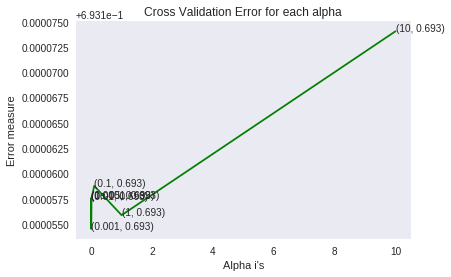

For values of best alpha =  0.001 The train log loss is: 0.6931453248593686
For values of best alpha =  0.001 The test log loss is: 0.6931505498036985
Total number of data points : 60000


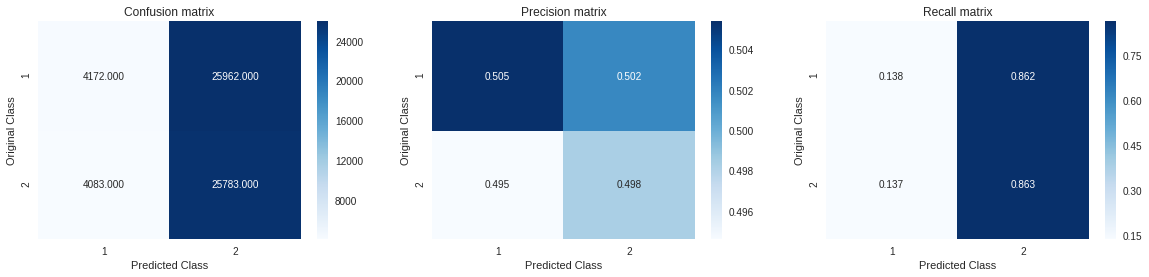

In [0]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: 
#------------------------------


log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(result_tfidf_w2v_train, y_train_tfidf_w2v)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(result_tfidf_w2v_train, y_train_tfidf_w2v)
    predict_y = sig_clf.predict_proba(result_tfidf_w2v_test)
    log_error_array.append(log_loss(y_test_tfidf_w2v, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test_tfidf_w2v, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(result_tfidf_w2v_train, y_train_tfidf_w2v)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(result_tfidf_w2v_train, y_train_tfidf_w2v)

predict_y = sig_clf.predict_proba(result_tfidf_w2v_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train_tfidf, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(result_tfidf_w2v_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test_tfidf, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test_tfidf_w2v, predicted_y)

<h2> 5.3 Linear SVM (TFIDF Vectors) with hyperparameter tuning </h2>

For values of alpha =  1e-05 The log loss is: 0.640481929129203
For values of alpha =  0.0001 The log loss is: 0.6343522077362349
For values of alpha =  0.001 The log loss is: 0.6429948382263273
For values of alpha =  0.01 The log loss is: 0.6612303311208646
For values of alpha =  0.1 The log loss is: 0.6612327173665996
For values of alpha =  1 The log loss is: 0.6612318538312896
For values of alpha =  10 The log loss is: 0.6612284889362576


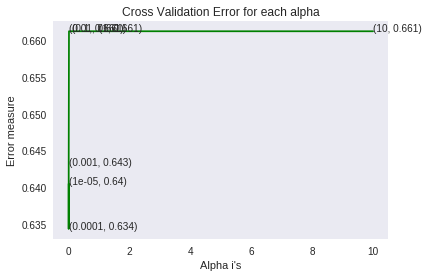

For values of best alpha =  0.0001 The train log loss is: 0.6315257580221483
For values of best alpha =  0.0001 The test log loss is: 0.6343522077362349
Total number of data points : 60000


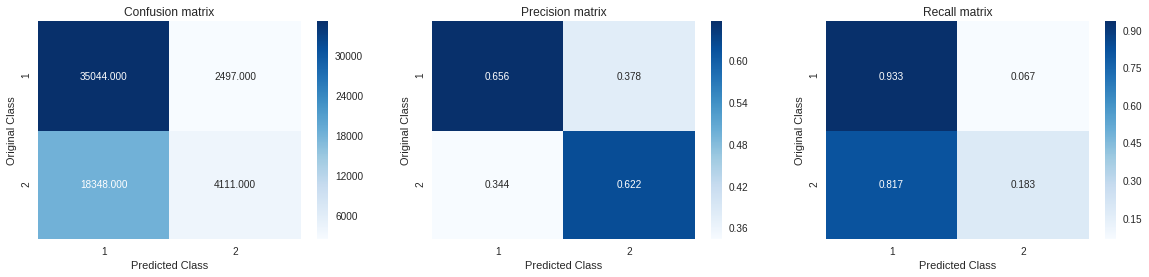

In [0]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: 
#------------------------------


log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l1', loss='hinge', random_state=42)
    clf.fit(result_tfidf_train, y_train_tfidf)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(result_tfidf_train, y_train_tfidf)
    predict_y = sig_clf.predict_proba(result_tfidf_test)
    log_error_array.append(log_loss(y_test_tfidf, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test_tfidf, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l1', loss='hinge', random_state=42)
clf.fit(result_tfidf_train, y_train_tfidf)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(result_tfidf_train, y_train_tfidf)

predict_y = sig_clf.predict_proba(result_tfidf_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train_tfidf, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(result_tfidf_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test_tfidf, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test_tfidf, predicted_y)

<h2> 5.3 Linear SVM (TFIDF W2V Vectors) with hyperparameter tuning </h2>

For values of alpha =  1e-05 The log loss is: 0.6593738015479585
For values of alpha =  0.0001 The log loss is: 0.6593738015479585
For values of alpha =  0.001 The log loss is: 0.6593656996272349
For values of alpha =  0.01 The log loss is: 0.6593738015479585
For values of alpha =  0.1 The log loss is: 0.6593738015479585
For values of alpha =  1 The log loss is: 0.6593745098935841
For values of alpha =  10 The log loss is: 0.6593732982636832


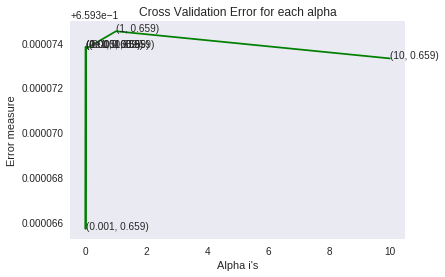

For values of best alpha =  0.001 The train log loss is: 0.6605951623182249
For values of best alpha =  0.001 The test log loss is: 0.6593656996272349
Total number of data points : 60000


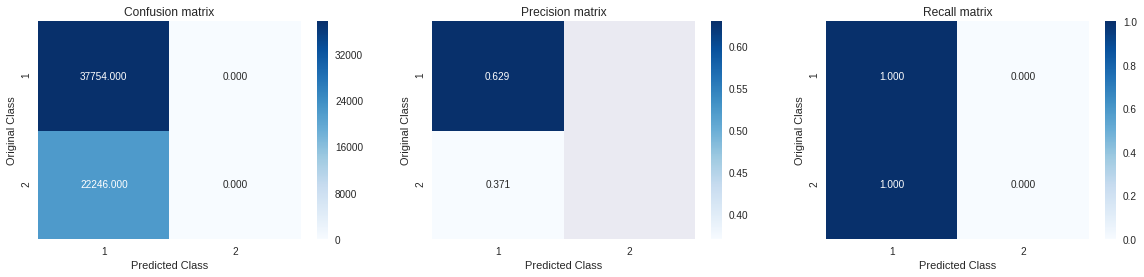

In [0]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: 
#------------------------------


log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l1', loss='hinge', random_state=42)
    clf.fit(result_tfidf_w2v_train, y_train_tfidf_w2v)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(result_tfidf_w2v_train, y_train_tfidf_w2v)
    predict_y = sig_clf.predict_proba(result_tfidf_w2v_test)
    log_error_array.append(log_loss(y_test_tfidf_w2v, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test_tfidf_w2v, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l1', loss='hinge', random_state=42)
clf.fit(result_tfidf_w2v_train, y_train_tfidf_w2v)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(result_tfidf_w2v_train, y_train_tfidf_w2v)

predict_y = sig_clf.predict_proba(result_tfidf_w2v_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train_tfidf_w2v, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(result_tfidf_w2v_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test_tfidf_w2v, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test_tfidf_w2v, predicted_y)

<h2> 5.4 XGBoost Model(TFIDF weighted word-**vectors**)  </h2>

In [0]:
import xgboost as xgb
params = {}
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'logloss'
params['eta'] = 0.02
params['max_depth'] = 4

d_train = xgb.DMatrix(result_tfidf_w2v_train, label=y_train_tfidf_w2v)
d_test = xgb.DMatrix(result_tfidf_w2v_test, label=y_test_tfidf_w2v)

watchlist = [(d_train, 'train'), (d_test, 'valid')]

bst = xgb.train(params, d_train, 400, watchlist, early_stopping_rounds=20, verbose_eval=10)

xgdmat = xgb.DMatrix(result_tfidf_w2v_train,y_train_tfidf_w2v)
predict_y = bst.predict(d_test)
print("The test log loss is:",log_loss(y_test_tfidf_w2v, predict_y, labels=clf.classes_, eps=1e-15))

[0]	train-logloss:0.691843	valid-logloss:0.691849
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 20 rounds.
[10]	train-logloss:0.681302	valid-logloss:0.681363
[20]	train-logloss:0.674185	valid-logloss:0.674286
[30]	train-logloss:0.669327	valid-logloss:0.669525
[40]	train-logloss:0.665943	valid-logloss:0.666316
[50]	train-logloss:0.66358	valid-logloss:0.664139
[60]	train-logloss:0.661909	valid-logloss:0.662658
[70]	train-logloss:0.660682	valid-logloss:0.661662
[80]	train-logloss:0.65977	valid-logloss:0.660993
[90]	train-logloss:0.659068	valid-logloss:0.660538
[100]	train-logloss:0.65851	valid-logloss:0.660233
[110]	train-logloss:0.658044	valid-logloss:0.660031
[120]	train-logloss:0.657679	valid-logloss:0.659905
[130]	train-logloss:0.657276	valid-logloss:0.659809
[140]	train-logloss:0.656977	valid-logloss:0.659747
[150]	train-logloss:0.656638	valid-logloss:0.6597
[160]	train-logloss:0.656352	vali

Total number of data points : 60000


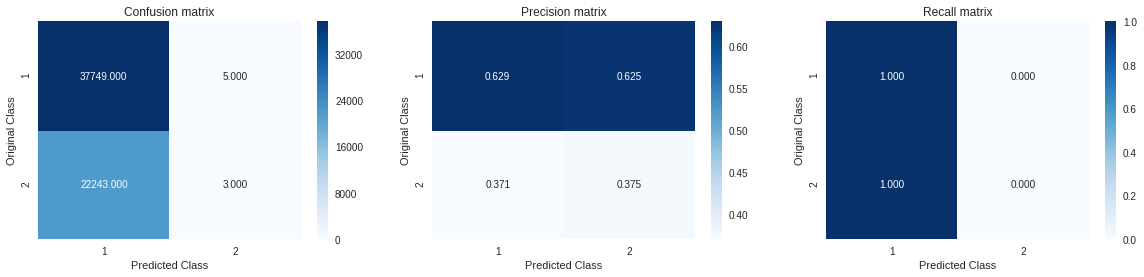

In [0]:
predicted_y =np.array(predict_y>0.5,dtype=int)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test_tfidf_w2v, predicted_y)

<h2> 5.4 XGBoost Model(TFIDF weighted word-**vectors**) with hyperparameter tuning  </h2>

In [0]:
from sklearn.model_selection import RandomizedSearchCV



start = dt.datetime.now()

params_fixed={
'objective':'binary:logistic',
'eval_metric':'logloss',
'silent': 1,
'nthread':-1}


params ={'max_depth':[1,2,3,4,5],
'n_estimators' : [100, 300, 500, 700, 900, 1000,1100],
'learning_rate' : [0.0001, 0.001, 0.01, 0.1,1,10],
'subsample' : [0.1,0.3,0.5,0.7,0.9,1],
'colsample_bytree' : [0.1, 0.3, 0.5, 0.7 , 0.9, 1]}

rs_grid =RandomizedSearchCV(
     estimator =XGBClassifier(**params_fixed),
     param_distributions=params,
     n_jobs=-1) 

print((result_tfidf_w2v_train.shape))
print((y_train_tfidf_w2v.shape))
rs_grid.fit(result_tfidf_w2v_train, y_train_tfidf_w2v)

rs_grid.cv_results_
print("\nTime Taken: ",dt.datetime.now() - start)

(140000, 626)
(140000,)


In [0]:
rs_grid.best_estimator_

NameError: ignored

In [0]:
rs_grid.best_params_

{'colsample_bytree': 0.7,
 'learning_rate': 0.0001,
 'max_depth': 2,
 'n_estimators': 500,
 'subsample': 0.3}

In [0]:
rs_grid.best_score_

0.6282428571428571

In [0]:
params = {}
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'logloss'
params['eta'] = 0.02
params['max_depth'] = 2
params['silent'] = 1
params['n_estimators'] =500
params['learning_rate'] = 0.0001
params['subsample'] = 0.3
params['colsample_bytree'] = 0.7


d_train = xgb.DMatrix(result_tfidf_w2v_train, label=y_train_tfidf_w2v)
d_test = xgb.DMatrix(result_tfidf_w2v_test, label=y_test_tfidf_w2v)

watchlist = [(d_train, 'train'), (d_test, 'valid')]

bst = xgb.train(params, d_train, 400, watchlist,verbose_eval= 10,early_stopping_rounds=20)

xgdmat = xgb.DMatrix(result_tfidf_w2v_train,y_train_tfidf_w2v)
predict_y = bst.predict(d_test)
print("The test log loss is:",log_loss(y_test_tfidf_w2v, predict_y, labels=clf.classes_, eps=1e-15))

[0]	train-logloss:0.693141	valid-logloss:0.693141
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 20 rounds.
[10]	train-logloss:0.693076	valid-logloss:0.693075
[20]	train-logloss:0.693011	valid-logloss:0.693009
[30]	train-logloss:0.692947	valid-logloss:0.692944
[40]	train-logloss:0.692882	valid-logloss:0.692879
[50]	train-logloss:0.692818	valid-logloss:0.692814
[60]	train-logloss:0.692754	valid-logloss:0.692749
[70]	train-logloss:0.692691	valid-logloss:0.692684
[80]	train-logloss:0.692626	valid-logloss:0.692619
[90]	train-logloss:0.692563	valid-logloss:0.692555
[100]	train-logloss:0.692499	valid-logloss:0.69249
[110]	train-logloss:0.692435	valid-logloss:0.692425
[120]	train-logloss:0.692371	valid-logloss:0.692361
[130]	train-logloss:0.692308	valid-logloss:0.692297
[140]	train-logloss:0.692245	valid-logloss:0.692233
[150]	train-logloss:0.692182	valid-logloss:0.692169
[160]	train-logloss:0.69212	v

Total number of data points : 60000


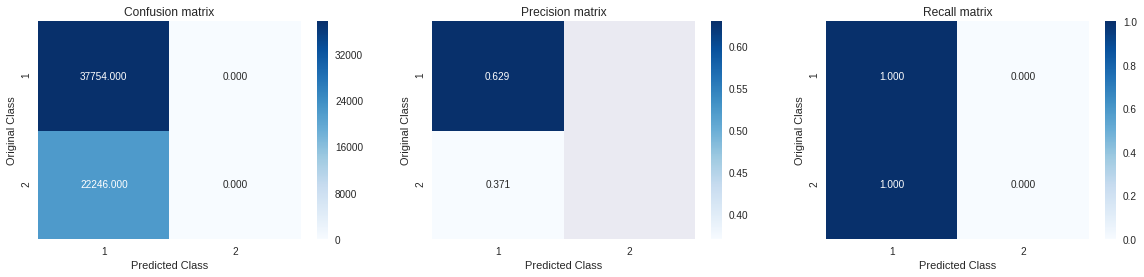

In [0]:
predicted_y =np.array(predict_y>0.5,dtype=int)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test_tfidf_w2v, predicted_y)


<h1> Conclusion </h1>

In [0]:
from prettytable import PrettyTable
ptable = PrettyTable()
ptable.field_names = ['Dataset Size', 'Model Name', 'Tokenizer', 'Test Log Loss']
ptable.add_row(["100K","Random","TFIDF Weighted W2V","0.89"])
ptable.add_row(["100K","Logistic Regression","TFIDF Weighted W2V","0.50"])
ptable.add_row(["100K","Linear SVM","TFIDF Weighted W2V","0.48"])
ptable.add_row(["100K","XGBoost","TFIDF Weighted W2V","0.35"])
ptable.add_row(["\n","\n","\n","\n"])
ptable.add_row(["100K","Logistic Regression","TFIDF","0.45"])
ptable.add_row(["100K","Linear SVM","TFIDF","0.45"])
ptable.add_row(["100K","XGBoost","TFIDF Weighted W2V","0.34"])
print(ptable)

+--------------+---------------------+--------------------+---------------+
| Dataset Size |      Model Name     |     Tokenizer      | Test Log Loss |
+--------------+---------------------+--------------------+---------------+
|     100K     |        Random       | TFIDF Weighted W2V |      0.89     |
|     100K     | Logistic Regression | TFIDF Weighted W2V |      0.50     |
|     100K     |      Linear SVM     | TFIDF Weighted W2V |      0.48     |
|     100K     |       XGBoost       | TFIDF Weighted W2V |      0.35     |
|              |                     |                    |               |
|              |                     |                    |               |
|     100K     | Logistic Regression |       TFIDF        |      0.45     |
|     100K     |      Linear SVM     |       TFIDF        |      0.45     |
|     100K     |       XGBoost       | TFIDF Weighted W2V |      0.34     |
+--------------+---------------------+--------------------+---------------+
